### Installing Dependencies

In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib

### Mount Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Set-Up

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import flwr as fl
from flwr.common import Metrics
import torchvision.models as models
import torch.optim as optim
import glob
import os

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cuda using PyTorch 2.0.0+cu118 and Flower 1.3.0


## Load Dataset

#### Define Torch Dataloader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(root='drive/MyDrive/archive/gaussian_filtered_images/gaussian_filtered_images', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

#### Display data

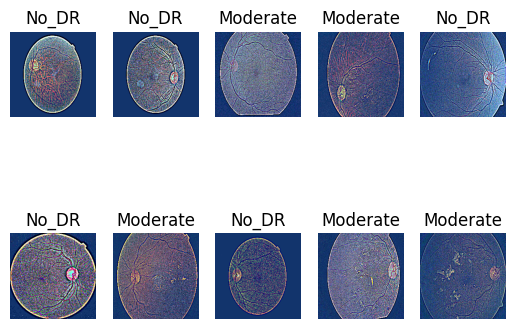

In [ ]:
def index_to_class_name(index, dataset):
    return dataset.classes[index]

len_images = 10
images, labels = next(iter(dataloader))
sample_indices = np.random.choice(len(images), len_images, replace=False)
sample_images = images[sample_indices]
sample_labels = labels[sample_indices]

for i, image in enumerate(sample_images):
    class_name = index_to_class_name(sample_labels[i], dataset)
    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_name)
    plt.axis('off')

plt.show() 

#### Data Splitter Utility

In [ ]:
BATCH_SIZE = 8

In [ ]:
def data_splitter(nodr=[0.2,0.2,0.2,0.2,0.2],mild=[0.2,0.2,0.2,0.2,0.2],moderate=[0.2,0.2,0.2,0.2,0.2],severe=[0.2,0.2,0.2,0.2,0.2],proliferate=[0.2,0.2,0.2,0.2,0.2],num_clients=5):
    datasets_individual=[]
    train_datasets_individual = []
    test_datasets_individual = []
    for i in range(5):
        classes = torch.tensor([i])
        # get indices that correspond to one of the selected classes
        indices = (torch.tensor(dataset.targets)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]
        data = torch.utils.data.Subset(dataset, indices) # subset the dataset
        datasets_individual.append(data)
    
    for i in range(5):
        train_temp, test_temp = torch.utils.data.random_split(datasets_individual[i], [int(0.8 * len(datasets_individual[i].indices)), len(datasets_individual[i].indices) - int(0.8 * len(datasets_individual[i].indices))])
        train_datasets_individual.append(train_temp)
        test_datasets_individual.append(test_temp)
    
    
    testset = torch.utils.data.ConcatDataset([test_datasets_individual[0],test_datasets_individual[1],test_datasets_individual[2],test_datasets_individual[3],test_datasets_individual[4]])

    train_datasets=[]
    for i in range(5):
        if dataset.classes[i]=="Mild":
            lengths=[a*len(train_datasets_individual[i]) for a in mild]
        elif dataset.classes[i]=="Moderate":
            lengths=[a*len(train_datasets_individual[i]) for a in moderate]
        elif dataset.classes[i]=="No_DR":
            lengths=[a*len(train_datasets_individual[i]) for a in nodr]
        elif dataset.classes[i]=="Proliferate_DR":
            lengths=[a*len(train_datasets_individual[i]) for a in proliferate]
        elif dataset.classes[i]=="Severe":
            lengths=[a*len(train_datasets_individual[i]) for a in severe]
        lengths=[int(l) for l in lengths]
        lengths[4]=len(train_datasets_individual[i])-sum(lengths[0:4])
        train_data = random_split(train_datasets_individual[i],lengths,torch.Generator().manual_seed(42))
        train_datasets.append(train_data)

    client_datasets=[]
    for i in range(num_clients):
        client_datasets.append(torch.utils.data.ConcatDataset([train_datasets[0][i],train_datasets[1][i],train_datasets[2][i],train_datasets[3][i],train_datasets[4][i]]))

    trainloaders = []
    valloaders = []
    test_len = len(testset) // num_clients
    test_lens = [test_len]*num_clients
    test_lens[-1] = len(testset) - test_len*(num_clients-1)
    valset = random_split(testset, test_lens, torch.Generator().manual_seed(42))

    for ds in client_datasets:
      trainloaders.append(DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True))

    for ds in valset:
      valloaders.append(DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True))

    return trainloaders, valloaders


In [ ]:
def split_dataset_to_equal_length_but_unequal_classes(num_clients=5):
    partition_size = len(dataset) // num_clients
    data_points_per_client_lengths = [partition_size]*num_clients
    data_points_per_client_lengths[-1] = len(dataset) - partition_size*(num_clients-1)

    dataset_for_clients = random_split(dataset, data_points_per_client_lengths, torch.Generator().manual_seed(42))

    trainloaders = []
    valloaders = []
    for ds in dataset_for_clients:
        len_val = len(ds) // 5  # 20 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True))
    
    return trainloaders, valloaders

In [ ]:
def split_dataset_for_global_training():
    trainset, testset= torch.utils.data.random_split(dataset, [2930, 732])
    trainSetLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testSetLoader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
    return trainSetLoader, testSetLoader

## Model Definition

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.alexnet = models.alexnet(pretrained=True)
        
        for param in self.alexnet.parameters():
            param.requires_grad = False
            
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, num_classes)

    def forward(self, x):
        x = self.alexnet(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(Net())

20485

In [ ]:
from tqdm import tqdm
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    print(optimizer)
    net.train()
    for epoch in range(epochs):
      correct, total, epoch_loss = 0, 0, 0.0
      for images, labels in tqdm(trainloader):
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          # Metrics
          epoch_loss += loss
          total += labels.size(0)
          correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
      epoch_loss /= len(trainloader.dataset)
      epoch_acc = correct / total
      if verbose:
          print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    # display_examples(dataset, dataloader, net)
    return loss, accuracy

In [ ]:
def print_data_split(trainloaders, valloaders):
    for i in range(len(trainloaders)):
        print("Client " + str(i+1) + " - Train Size: " + str(len(trainloaders[i].dataset)))
        print("Client " + str(i+1) + " - Test Size: " + str(len(valloaders[i].dataset)))

## Utility for printing the positive and negative cases

In [ ]:
from matplotlib.pyplot import figure
def index_to_class_name(index, dataset):
    return dataset.classes[index]


def display_images(dataset, img_list, plabel_list, alabel_list):
    figure(figsize=(8, 6), dpi=80)
    for i, (img, plabel, alabel) in enumerate(zip(img_list, plabel_list, alabel_list)):
        predicted_class_name = index_to_class_name(plabel, dataset)
        actual_class_name = index_to_class_name(alabel, dataset)
        plt.subplot(2, 3, i+1)
        plt.subplots_adjust(hspace=0.5)
        
        plt.imshow(img.cpu().permute(1, 2, 0))
        plt.title("Predicted: " + predicted_class_name + "\n Actual: " + actual_class_name)
        plt.axis('off')
    

def display_examples(dataset, dataloader, model):
    """
    dataset: torch.ImageDataset
    dataloader: torch.dataloader
    model: pytorch model 
    """
    
    case1_img, case1_plabel, case1_alabel = [], [], []
    case2_img, case2_plabel, case2_alabel = [], [], []
    images, labels = next(iter(dataloader))
    for img, actual_lbl in zip(images, labels):
        img = torch.unsqueeze(img, dim=0)
        img=img.cuda()
        predicted_lbl = torch.argmax(model(img)[0]).item()
        if predicted_lbl == actual_lbl and len(case1_img) < 3:
            case1_img.append(torch.squeeze(img, dim = 0))
            case1_plabel.append(predicted_lbl)
            case1_alabel.append(actual_lbl)
        elif predicted_lbl != actual_lbl and len(case2_img) < 3:
            case2_img.append(torch.squeeze(img, dim = 0))
            case2_plabel.append(predicted_lbl)
            case2_alabel.append(actual_lbl)
            
    display_images(dataset, case2_img, case2_plabel, case2_alabel)
    plt.show()
    display_images(dataset, case1_img, case1_plabel, case1_alabel)

## Global Training (Without Federated Learning)

In [ ]:
train_global,val_global = split_dataset_for_global_training()

In [ ]:
net = Net().to(DEVICE)
for i in range(5):
    train(net, train_global, 1)
    loss_global, accuracy_global = test(net, val_global)
    print(f"Epoch {i+1}:  validation loss {loss_global}, accuracy {accuracy_global}")

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


100%|██████████| 92/92 [00:03<00:00, 23.95it/s]


Epoch 1:  validation loss 0.09814644047145635, accuracy 0.7486338797814208
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


100%|██████████| 92/92 [00:04<00:00, 22.81it/s]


Epoch 2:  validation loss 0.09361694161805624, accuracy 0.703551912568306
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


100%|██████████| 92/92 [00:04<00:00, 21.13it/s]


Epoch 3:  validation loss 0.10476208273626741, accuracy 0.7021857923497268
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


100%|██████████| 92/92 [00:04<00:00, 22.08it/s]


Epoch 4:  validation loss 0.08683673662891805, accuracy 0.75
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


100%|██████████| 92/92 [00:03<00:00, 24.19it/s]

Epoch 5:  validation loss 0.1291067429660448, accuracy 0.6024590163934426


## Federated Learning

#### Utility Functions

In [ ]:
net = Net().to(DEVICE)
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):
        """Aggregate model weights using weighted average and store checkpoint"""


        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = {k: torch.tensor(v) for k, v in params_dict}
            net.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(net.state_dict(), f"model_round_{server_round}.pth")

        return aggregated_parameters, aggregated_metrics

In [ ]:
def get_parameters(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = {k: torch.Tensor(v) for k, v in params_dict}
    net.load_state_dict(state_dict, strict=True)

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [ ]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    local_accuracies = [m["accuracy"] for num_examples, m in metrics]
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"global accuracy": sum(accuracies) / sum(examples), "local accuracies":local_accuracies}

# Can return individual if needed

In [ ]:
def run_fedAvg(num_of_rounds=5):
  strategy = SaveModelStrategy(
          fraction_fit=1.0,
          evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
      )
  client_resources = None
  if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

  fl.simulation.start_simulation(
          client_fn=client_fn,
          num_clients=NUM_CLIENTS,
          config=fl.server.ServerConfig(num_rounds=num_of_rounds),
          strategy=strategy,
          client_resources=client_resources,
      )

In [ ]:
def load_weights():
  list_of_files = [fname for fname in glob.glob("./model_round_*")]
  latest_round_file = max(list_of_files, key=os.path.getctime)
  print("Loading pre-trained model from: ", latest_round_file)
  state_dict = torch.load(latest_round_file)
  net.load_state_dict(state_dict)

#### Starting federated learning with Number of Clients as 5 with strategy FedAvg

In [ ]:
NUM_CLIENTS = 5

#### Case 1: Equal Length Data & Unequal Classes

In [ ]:
trainloaders, valloaders = split_dataset_to_equal_length_but_unequal_classes(NUM_CLIENTS)

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 586
Client 1 - Test Size: 146
Client 2 - Train Size: 586
Client 2 - Test Size: 146
Client 3 - Train Size: 586
Client 3 - Test Size: 146
Client 4 - Train Size: 586
Client 4 - Test Size: 146
Client 5 - Train Size: 588
Client 5 - Test Size: 146


In [ ]:
net = Net().to(DEVICE)
run_fedAvg()

INFO flwr 2023-04-19 23:43:26,941 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-19 23:43:32,637	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-19 23:43:34,295 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 3964170240.0, 'memory': 7928340480.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 3964170240.0, 'memory': 7928340480.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-04-19 23:43:34,301 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-19 23:43:34,304 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=31525) Adam (
(launch_and_fit pid=31525) Parameter Group 0
(launch_and_fit pid=31525)     amsgrad: False
(launch_and_fit pid=31525)     betas: (0.9, 0.999)
(launch_and_fit pid=31525)     capturable: False
(launch_and_fit pid=31525)     differentiable: False
(launch_and_fit pid=31525)     eps: 1e-08
(launch_and_fit pid=31525)     foreach: None
(launch_and_fit pid=31525)     fused: None
(launch_and_fit pid=31525)     lr: 0.001
(launch_and_fit pid=31525)     maximize: False
(launch_and_fit pid=31525)     weight_decay: 0
(launch_and_fit pid=31525) )


100%|██████████| 74/74 [00:03<00:00, 19.25it/s]
(launch_and_fit pid=31629) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=31629)   warnings.warn(
(launch_and_fit pid=31629) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=31629)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=31629) Adam (
(launch_and_fit pid=31629) Parameter Group 0
(launch_and_fit pid=31629)     amsgrad: False
(launch_and_fit pid=31629)     betas: (0.9, 0.999)
(launch_and_fit pid=31629)     capturable: False
(launch_and_fit pid=31629)     differentiable: False
(launch_and_fit pid=31629)     eps: 1e-08
(launch_and_fit pid=31629)     foreach: None
(launch_and_fit pid=31629)     fused: None
(launch_and_fit pid=31629)     lr: 0.001
(launch_and_fit pid=31629)     maximize: False
(launch_and_fit pid=31629)     weight_decay: 0
(launch_and_fit pid=31629) )


100%|██████████| 74/74 [00:03<00:00, 22.44it/s]
(launch_and_fit pid=31732) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=31732)   warnings.warn(
(launch_and_fit pid=31732) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=31732)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=31732) Adam (
(launch_and_fit pid=31732) Parameter Group 0
(launch_and_fit pid=31732)     amsgrad: False
(launch_and_fit pid=31732)     betas: (0.9, 0.999)
(launch_and_fit pid=31732)     capturable: False
(launch_and_fit pid=31732)     differentiable: False
(launch_and_fit pid=31732)     eps: 1e-08
(launch_and_fit pid=31732)     foreach: None
(launch_and_fit pid=31732)     fused: None
(launch_and_fit pid=31732)     lr: 0.001
(launch_and_fit pid=31732)     maximize: False
(launch_and_fit pid=31732)     weight_decay: 0
(launch_and_fit pid=31732) )


100%|██████████| 74/74 [00:03<00:00, 19.05it/s]
(launch_and_fit pid=31835) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=31835)   warnings.warn(
(launch_and_fit pid=31835) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=31835)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=31835) Adam (
(launch_and_fit pid=31835) Parameter Group 0
(launch_and_fit pid=31835)     amsgrad: False
(launch_and_fit pid=31835)     betas: (0.9, 0.999)
(launch_and_fit pid=31835)     capturable: False
(launch_and_fit pid=31835)     differentiable: False
(launch_and_fit pid=31835)     eps: 1e-08
(launch_and_fit pid=31835)     foreach: None
(launch_and_fit pid=31835)     fused: None
(launch_and_fit pid=31835)     lr: 0.001
(launch_and_fit pid=31835)     maximize: False
(launch_and_fit pid=31835)     weight_decay: 0
(launch_and_fit pid=31835) )


100%|██████████| 74/74 [00:03<00:00, 22.32it/s]
(launch_and_fit pid=31933) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=31933)   warnings.warn(
(launch_and_fit pid=31933) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=31933)   warnings.warn(msg)


(launch_and_fit pid=31933) Adam (
(launch_and_fit pid=31933) Parameter Group 0
(launch_and_fit pid=31933)     amsgrad: False
(launch_and_fit pid=31933)     betas: (0.9, 0.999)
(launch_and_fit pid=31933)     capturable: False
(launch_and_fit pid=31933)     differentiable: False
(launch_and_fit pid=31933)     eps: 1e-08
(launch_and_fit pid=31933)     foreach: None
(launch_and_fit pid=31933)     fused: None
(launch_and_fit pid=31933)     lr: 0.001
(launch_and_fit pid=31933)     maximize: False
(launch_and_fit pid=31933)     weight_decay: 0
(launch_and_fit pid=31933) )


100%|██████████| 74/74 [00:03<00:00, 18.93it/s]
DEBUG flwr 2023-04-19 23:44:20,960 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-19 23:44:23,875 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-04-19 23:44:24,890 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=32063) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=32063)   warnings.warn(
(launch_and_evaluate pid=32063) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=32063)   warnings.warn(msg)
100%|██████████| 19/19 [00:00<00:00, 19.46it/s]
(launch_and_evaluate pid=3212

(scheduler +5m39s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +5m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_fit pid=32393) Adam (
(launch_and_fit pid=32393) Parameter Group 0
(launch_and_fit pid=32393)     amsgrad: False
(launch_and_fit pid=32393)     betas: (0.9, 0.999)
(launch_and_fit pid=32393)     capturable: False
(launch_and_fit pid=32393)     differentiable: False
(launch_and_fit pid=32393)     eps: 1e-08
(launch_and_fit pid=32393)     foreach: None
(launch_and_fit pid=32393)     fused: None
(launch_and_fit pid=32393)     lr: 0.001
(launch_and_fit pid=32393)     maximize: False
(launch_and_fit pid=32393)     weight_decay: 0
(launch_and_fit pid=32393) )


100%|██████████| 74/74 [00:03<00:00, 22.27it/s]
(launch_and_fit pid=32501) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=32501)   warnings.warn(
(launch_and_fit pid=32501) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=32501)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=32501) Adam (
(launch_and_fit pid=32501) Parameter Group 0
(launch_and_fit pid=32501)     amsgrad: False
(launch_and_fit pid=32501)     betas: (0.9, 0.999)
(launch_and_fit pid=32501)     capturable: False
(launch_and_fit pid=32501)     differentiable: False
(launch_and_fit pid=32501)     eps: 1e-08
(launch_and_fit pid=32501)     foreach: None
(launch_and_fit pid=32501)     fused: None
(launch_and_fit pid=32501)     lr: 0.001
(launch_and_fit pid=32501)     maximize: False
(launch_and_fit pid=32501)     weight_decay: 0
(launch_and_fit pid=32501) )


100%|██████████| 74/74 [00:03<00:00, 20.95it/s]
(launch_and_fit pid=32601) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=32601)   warnings.warn(
(launch_and_fit pid=32601) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=32601)   warnings.warn(msg)


(launch_and_fit pid=32601) Adam (
(launch_and_fit pid=32601) Parameter Group 0
(launch_and_fit pid=32601)     amsgrad: False
(launch_and_fit pid=32601)     betas: (0.9, 0.999)
(launch_and_fit pid=32601)     capturable: False
(launch_and_fit pid=32601)     differentiable: False
(launch_and_fit pid=32601)     eps: 1e-08
(launch_and_fit pid=32601)     foreach: None
(launch_and_fit pid=32601)     fused: None
(launch_and_fit pid=32601)     lr: 0.001
(launch_and_fit pid=32601)     maximize: False
(launch_and_fit pid=32601)     weight_decay: 0
(launch_and_fit pid=32601) )


100%|██████████| 74/74 [00:03<00:00, 22.78it/s]
(launch_and_fit pid=32705) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=32705)   warnings.warn(
(launch_and_fit pid=32705) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=32705)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=32705) Adam (
(launch_and_fit pid=32705) Parameter Group 0
(launch_and_fit pid=32705)     amsgrad: False
(launch_and_fit pid=32705)     betas: (0.9, 0.999)
(launch_and_fit pid=32705)     capturable: False
(launch_and_fit pid=32705)     differentiable: False
(launch_and_fit pid=32705)     eps: 1e-08
(launch_and_fit pid=32705)     foreach: None
(launch_and_fit pid=32705)     fused: None
(launch_and_fit pid=32705)     lr: 0.001
(launch_and_fit pid=32705)     maximize: False
(launch_and_fit pid=32705)     weight_decay: 0
(launch_and_fit pid=32705) )


100%|██████████| 74/74 [00:03<00:00, 20.32it/s]
(launch_and_fit pid=32803) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=32803)   warnings.warn(
(launch_and_fit pid=32803) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=32803)   warnings.warn(msg)


(launch_and_fit pid=32803) Adam (
(launch_and_fit pid=32803) Parameter Group 0
(launch_and_fit pid=32803)     amsgrad: False
(launch_and_fit pid=32803)     betas: (0.9, 0.999)
(launch_and_fit pid=32803)     capturable: False
(launch_and_fit pid=32803)     differentiable: False
(launch_and_fit pid=32803)     eps: 1e-08
(launch_and_fit pid=32803)     foreach: None
(launch_and_fit pid=32803)     fused: None
(launch_and_fit pid=32803)     lr: 0.001
(launch_and_fit pid=32803)     maximize: False
(launch_and_fit pid=32803)     weight_decay: 0
(launch_and_fit pid=32803) )


100%|██████████| 74/74 [00:03<00:00, 22.58it/s]
DEBUG flwr 2023-04-19 23:45:36,127 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-04-19 23:45:40,552 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)


(scheduler +6m30s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(raylet) Spilled 2616 MiB, 28 objects, write throughput 183 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(launch_and_evaluate pid=32935) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=32935)   warnings.warn(
(launch_and_evaluate pid=32935) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=32935)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 15.07it/s]
(launch_and_evaluate pid=33184) /usr/local/lib/python3.9/dist-packages/torchvision/m

(launch_and_fit pid=33492) Adam (
(launch_and_fit pid=33492) Parameter Group 0
(launch_and_fit pid=33492)     amsgrad: False
(launch_and_fit pid=33492)     betas: (0.9, 0.999)
(launch_and_fit pid=33492)     capturable: False
(launch_and_fit pid=33492)     differentiable: False
(launch_and_fit pid=33492)     eps: 1e-08
(launch_and_fit pid=33492)     foreach: None
(launch_and_fit pid=33492)     fused: None
(launch_and_fit pid=33492)     lr: 0.001
(launch_and_fit pid=33492)     maximize: False
(launch_and_fit pid=33492)     weight_decay: 0
(launch_and_fit pid=33492) )


100%|██████████| 74/74 [00:04<00:00, 17.08it/s]
(launch_and_fit pid=33614) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=33614)   warnings.warn(
(launch_and_fit pid=33614) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=33614)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=33614) Adam (
(launch_and_fit pid=33614) Parameter Group 0
(launch_and_fit pid=33614)     amsgrad: False
(launch_and_fit pid=33614)     betas: (0.9, 0.999)
(launch_and_fit pid=33614)     capturable: False
(launch_and_fit pid=33614)     differentiable: False
(launch_and_fit pid=33614)     eps: 1e-08
(launch_and_fit pid=33614)     foreach: None
(launch_and_fit pid=33614)     fused: None
(launch_and_fit pid=33614)     lr: 0.001
(launch_and_fit pid=33614)     maximize: False
(launch_and_fit pid=33614)     weight_decay: 0
(launch_and_fit pid=33614) )


100%|██████████| 74/74 [00:04<00:00, 16.89it/s]
(launch_and_fit pid=33737) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=33737)   warnings.warn(
(launch_and_fit pid=33737) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=33737)   warnings.warn(msg)


(launch_and_fit pid=33737) Adam (
(launch_and_fit pid=33737) Parameter Group 0
(launch_and_fit pid=33737)     amsgrad: False
(launch_and_fit pid=33737)     betas: (0.9, 0.999)
(launch_and_fit pid=33737)     capturable: False
(launch_and_fit pid=33737)     differentiable: False
(launch_and_fit pid=33737)     eps: 1e-08
(launch_and_fit pid=33737)     foreach: None
(launch_and_fit pid=33737)     fused: None
(launch_and_fit pid=33737)     lr: 0.001
(launch_and_fit pid=33737)     maximize: False
(launch_and_fit pid=33737)     weight_decay: 0
(launch_and_fit pid=33737) )


100%|██████████| 74/74 [00:04<00:00, 16.18it/s]
(launch_and_fit pid=33851) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=33851)   warnings.warn(
(launch_and_fit pid=33851) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=33851)   warnings.warn(msg)


(launch_and_fit pid=33851) Adam (
(launch_and_fit pid=33851) Parameter Group 0
(launch_and_fit pid=33851)     amsgrad: False
(launch_and_fit pid=33851)     betas: (0.9, 0.999)
(launch_and_fit pid=33851)     capturable: False
(launch_and_fit pid=33851)     differentiable: False
(launch_and_fit pid=33851)     eps: 1e-08
(launch_and_fit pid=33851)     foreach: None
(launch_and_fit pid=33851)     fused: None
(launch_and_fit pid=33851)     lr: 0.001
(launch_and_fit pid=33851)     maximize: False
(launch_and_fit pid=33851)     weight_decay: 0
(launch_and_fit pid=33851) )


100%|██████████| 74/74 [00:04<00:00, 18.16it/s]
(launch_and_fit pid=33964) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=33964)   warnings.warn(
(launch_and_fit pid=33964) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=33964)   warnings.warn(msg)


(launch_and_fit pid=33964) Adam (
(launch_and_fit pid=33964) Parameter Group 0
(launch_and_fit pid=33964)     amsgrad: False
(launch_and_fit pid=33964)     betas: (0.9, 0.999)
(launch_and_fit pid=33964)     capturable: False
(launch_and_fit pid=33964)     differentiable: False
(launch_and_fit pid=33964)     eps: 1e-08
(launch_and_fit pid=33964)     foreach: None
(launch_and_fit pid=33964)     fused: None
(launch_and_fit pid=33964)     lr: 0.001
(launch_and_fit pid=33964)     maximize: False
(launch_and_fit pid=33964)     weight_decay: 0
(launch_and_fit pid=33964) )


100%|██████████| 74/74 [00:05<00:00, 14.48it/s]
DEBUG flwr 2023-04-19 23:47:20,641 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-04-19 23:47:26,338 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=34118) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=34118)   warnings.warn(
(launch_and_evaluate pid=34118) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=34118)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 10.17it/s]
(launch_and_evaluate pid=3422

(launch_and_fit pid=34512) Adam (
(launch_and_fit pid=34512) Parameter Group 0
(launch_and_fit pid=34512)     amsgrad: False
(launch_and_fit pid=34512)     betas: (0.9, 0.999)
(launch_and_fit pid=34512)     capturable: False
(launch_and_fit pid=34512)     differentiable: False
(launch_and_fit pid=34512)     eps: 1e-08
(launch_and_fit pid=34512)     foreach: None
(launch_and_fit pid=34512)     fused: None
(launch_and_fit pid=34512)     lr: 0.001
(launch_and_fit pid=34512)     maximize: False
(launch_and_fit pid=34512)     weight_decay: 0
(launch_and_fit pid=34512) )


100%|██████████| 74/74 [00:05<00:00, 12.46it/s]
(launch_and_fit pid=34653) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=34653)   warnings.warn(
(launch_and_fit pid=34653) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=34653)   warnings.warn(msg)


(launch_and_fit pid=34653) Adam (
(launch_and_fit pid=34653) Parameter Group 0
(launch_and_fit pid=34653)     amsgrad: False
(launch_and_fit pid=34653)     betas: (0.9, 0.999)
(launch_and_fit pid=34653)     capturable: False
(launch_and_fit pid=34653)     differentiable: False
(launch_and_fit pid=34653)     eps: 1e-08
(launch_and_fit pid=34653)     foreach: None
(launch_and_fit pid=34653)     fused: None
(launch_and_fit pid=34653)     lr: 0.001
(launch_and_fit pid=34653)     maximize: False
(launch_and_fit pid=34653)     weight_decay: 0
(launch_and_fit pid=34653) )


100%|██████████| 74/74 [00:04<00:00, 17.03it/s]
(launch_and_fit pid=34765) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=34765)   warnings.warn(
(launch_and_fit pid=34765) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=34765)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=34765) Adam (
(launch_and_fit pid=34765) Parameter Group 0
(launch_and_fit pid=34765)     amsgrad: False
(launch_and_fit pid=34765)     betas: (0.9, 0.999)
(launch_and_fit pid=34765)     capturable: False
(launch_and_fit pid=34765)     differentiable: False
(launch_and_fit pid=34765)     eps: 1e-08
(launch_and_fit pid=34765)     foreach: None
(launch_and_fit pid=34765)     fused: None
(launch_and_fit pid=34765)     lr: 0.001
(launch_and_fit pid=34765)     maximize: False
(launch_and_fit pid=34765)     weight_decay: 0
(launch_and_fit pid=34765) )


100%|██████████| 74/74 [00:04<00:00, 17.16it/s]
(launch_and_fit pid=34882) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=34882)   warnings.warn(
(launch_and_fit pid=34882) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=34882)   warnings.warn(msg)


(launch_and_fit pid=34882) Adam (
(launch_and_fit pid=34882) Parameter Group 0
(launch_and_fit pid=34882)     amsgrad: False
(launch_and_fit pid=34882)     betas: (0.9, 0.999)
(launch_and_fit pid=34882)     capturable: False
(launch_and_fit pid=34882)     differentiable: False
(launch_and_fit pid=34882)     eps: 1e-08
(launch_and_fit pid=34882)     foreach: None
(launch_and_fit pid=34882)     fused: None
(launch_and_fit pid=34882)     lr: 0.001
(launch_and_fit pid=34882)     maximize: False
(launch_and_fit pid=34882)     weight_decay: 0
(launch_and_fit pid=34882) )


100%|██████████| 74/74 [00:05<00:00, 14.32it/s]
(launch_and_fit pid=35003) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=35003)   warnings.warn(
(launch_and_fit pid=35003) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=35003)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=35003) Adam (
(launch_and_fit pid=35003) Parameter Group 0
(launch_and_fit pid=35003)     amsgrad: False
(launch_and_fit pid=35003)     betas: (0.9, 0.999)
(launch_and_fit pid=35003)     capturable: False
(launch_and_fit pid=35003)     differentiable: False
(launch_and_fit pid=35003)     eps: 1e-08
(launch_and_fit pid=35003)     foreach: None
(launch_and_fit pid=35003)     fused: None
(launch_and_fit pid=35003)     lr: 0.001
(launch_and_fit pid=35003)     maximize: False
(launch_and_fit pid=35003)     weight_decay: 0
(launch_and_fit pid=35003) )


100%|██████████| 74/74 [00:04<00:00, 17.90it/s]
DEBUG flwr 2023-04-19 23:48:59,484 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-04-19 23:49:05,922 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=35150) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=35150)   warnings.warn(
(launch_and_evaluate pid=35150) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=35150)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 12.72it/s]
(launch_and_evaluate pid=3524

(scheduler +10m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_fit pid=35532) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=35532)   warnings.warn(
(launch_and_fit pid=35532) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=35532)   warnings.warn(msg)


(launch_and_fit pid=35532) Adam (
(launch_and_fit pid=35532) Parameter Group 0
(launch_and_fit pid=35532)     amsgrad: False
(launch_and_fit pid=35532)     betas: (0.9, 0.999)
(launch_and_fit pid=35532)     capturable: False
(launch_and_fit pid=35532)     differentiable: False
(launch_and_fit pid=35532)     eps: 1e-08
(launch_and_fit pid=35532)     foreach: None
(launch_and_fit pid=35532)     fused: None
(launch_and_fit pid=35532)     lr: 0.001
(launch_and_fit pid=35532)     maximize: False
(launch_and_fit pid=35532)     weight_decay: 0
(launch_and_fit pid=35532) )


100%|██████████| 74/74 [00:04<00:00, 16.19it/s]
(raylet) Spilled 8282 MiB, 79 objects, write throughput 214 MiB/s.
(launch_and_fit pid=35664) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=35664)   warnings.warn(
(launch_and_fit pid=35664) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=35664)   warnings.warn(msg)


(launch_and_fit pid=35664) Adam (
(launch_and_fit pid=35664) Parameter Group 0
(launch_and_fit pid=35664)     amsgrad: False
(launch_and_fit pid=35664)     betas: (0.9, 0.999)
(launch_and_fit pid=35664)     capturable: False
(launch_and_fit pid=35664)     differentiable: False
(launch_and_fit pid=35664)     eps: 1e-08
(launch_and_fit pid=35664)     foreach: None
(launch_and_fit pid=35664)     fused: None
(launch_and_fit pid=35664)     lr: 0.001
(launch_and_fit pid=35664)     maximize: False
(launch_and_fit pid=35664)     weight_decay: 0
(launch_and_fit pid=35664) )


100%|██████████| 74/74 [00:05<00:00, 13.43it/s]
(launch_and_fit pid=35795) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=35795)   warnings.warn(
(launch_and_fit pid=35795) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=35795)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=35795) Adam (
(launch_and_fit pid=35795) Parameter Group 0
(launch_and_fit pid=35795)     amsgrad: False
(launch_and_fit pid=35795)     betas: (0.9, 0.999)
(launch_and_fit pid=35795)     capturable: False
(launch_and_fit pid=35795)     differentiable: False
(launch_and_fit pid=35795)     eps: 1e-08
(launch_and_fit pid=35795)     foreach: None
(launch_and_fit pid=35795)     fused: None
(launch_and_fit pid=35795)     lr: 0.001
(launch_and_fit pid=35795)     maximize: False
(launch_and_fit pid=35795)     weight_decay: 0
(launch_and_fit pid=35795) )


100%|██████████| 74/74 [00:04<00:00, 16.09it/s]
(launch_and_fit pid=35908) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=35908)   warnings.warn(
(launch_and_fit pid=35908) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=35908)   warnings.warn(msg)


(launch_and_fit pid=35908) Adam (
(launch_and_fit pid=35908) Parameter Group 0
(launch_and_fit pid=35908)     amsgrad: False
(launch_and_fit pid=35908)     betas: (0.9, 0.999)
(launch_and_fit pid=35908)     capturable: False
(launch_and_fit pid=35908)     differentiable: False
(launch_and_fit pid=35908)     eps: 1e-08
(launch_and_fit pid=35908)     foreach: None
(launch_and_fit pid=35908)     fused: None
(launch_and_fit pid=35908)     lr: 0.001
(launch_and_fit pid=35908)     maximize: False
(launch_and_fit pid=35908)     weight_decay: 0
(launch_and_fit pid=35908) )


100%|██████████| 74/74 [00:04<00:00, 15.66it/s]
(launch_and_fit pid=36025) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=36025)   warnings.warn(
(launch_and_fit pid=36025) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=36025)   warnings.warn(msg)


(launch_and_fit pid=36025) Adam (
(launch_and_fit pid=36025) Parameter Group 0
(launch_and_fit pid=36025)     amsgrad: False
(launch_and_fit pid=36025)     betas: (0.9, 0.999)
(launch_and_fit pid=36025)     capturable: False
(launch_and_fit pid=36025)     differentiable: False
(launch_and_fit pid=36025)     eps: 1e-08
(launch_and_fit pid=36025)     foreach: None
(launch_and_fit pid=36025)     fused: None
(launch_and_fit pid=36025)     lr: 0.001
(launch_and_fit pid=36025)     maximize: False
(launch_and_fit pid=36025)     weight_decay: 0
(launch_and_fit pid=36025) )


100%|██████████| 74/74 [00:04<00:00, 16.97it/s]
DEBUG flwr 2023-04-19 23:50:36,321 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-04-19 23:50:43,604 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=36178) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=36178)   warnings.warn(
(launch_and_evaluate pid=36178) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=36178)   warnings.warn(msg)
100%|██████████| 19/19 [00:03<00:00,  6.18it/s]
(launch_and_evaluate pid=3628

Loading pre-trained model from:  ./model_round_5.pth


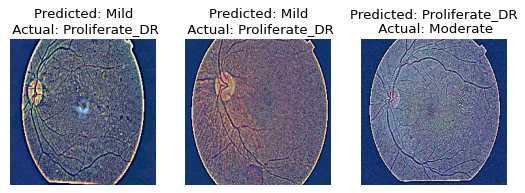

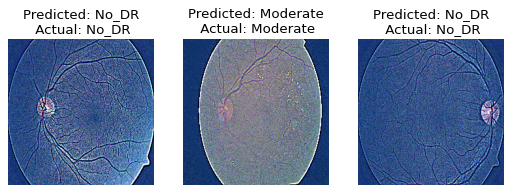

In [ ]:
load_weights()
display_examples(dataset, dataloader, net)


#### Case 2: Equal Length Data & Equal Classes

In [ ]:
trainloaders, valloaders = data_splitter()

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 583
Client 1 - Test Size: 146
Client 2 - Train Size: 583
Client 2 - Test Size: 146
Client 3 - Train Size: 583
Client 3 - Test Size: 146
Client 4 - Train Size: 583
Client 4 - Test Size: 146
Client 5 - Train Size: 597
Client 5 - Test Size: 149


In [ ]:
net = Net().to(DEVICE)
run_fedAvg()

INFO flwr 2023-04-20 00:14:28,032 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-20 00:14:34,062	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-20 00:14:35,580 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 8010090087.0, 'GPU': 1.0, 'object_store_memory': 4005045043.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 8010090087.0, 'GPU': 1.0, 'object_store_memory': 4005045043.0}
INFO flwr 2023-04-20 00:14:35,586 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-20 00:14:35,594 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=43099) Adam (
(launch_and_fit pid=43099) Parameter Group 0
(launch_and_fit pid=43099)     amsgrad: False
(launch_and_fit pid=43099)     betas: (0.9, 0.999)
(launch_and_fit pid=43099)     capturable: False
(launch_and_fit pid=43099)     differentiable: False
(launch_and_fit pid=43099)     eps: 1e-08
(launch_and_fit pid=43099)     foreach: None
(launch_and_fit pid=43099)     fused: None
(launch_and_fit pid=43099)     lr: 0.001
(launch_and_fit pid=43099)     maximize: False
(launch_and_fit pid=43099)     weight_decay: 0
(launch_and_fit pid=43099) )


100%|██████████| 73/73 [00:04<00:00, 14.98it/s]
(launch_and_fit pid=43219) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=43219)   warnings.warn(
(launch_and_fit pid=43219) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=43219)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=43219) Adam (
(launch_and_fit pid=43219) Parameter Group 0
(launch_and_fit pid=43219)     amsgrad: False
(launch_and_fit pid=43219)     betas: (0.9, 0.999)
(launch_and_fit pid=43219)     capturable: False
(launch_and_fit pid=43219)     differentiable: False
(launch_and_fit pid=43219)     eps: 1e-08
(launch_and_fit pid=43219)     foreach: None
(launch_and_fit pid=43219)     fused: None
(launch_and_fit pid=43219)     lr: 0.001
(launch_and_fit pid=43219)     maximize: False
(launch_and_fit pid=43219)     weight_decay: 0
(launch_and_fit pid=43219) )


100%|██████████| 73/73 [00:05<00:00, 14.44it/s]
(launch_and_fit pid=43332) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=43332)   warnings.warn(
(launch_and_fit pid=43332) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=43332)   warnings.warn(msg)


(launch_and_fit pid=43332) Adam (
(launch_and_fit pid=43332) Parameter Group 0
(launch_and_fit pid=43332)     amsgrad: False
(launch_and_fit pid=43332)     betas: (0.9, 0.999)
(launch_and_fit pid=43332)     capturable: False
(launch_and_fit pid=43332)     differentiable: False
(launch_and_fit pid=43332)     eps: 1e-08
(launch_and_fit pid=43332)     foreach: None
(launch_and_fit pid=43332)     fused: None
(launch_and_fit pid=43332)     lr: 0.001
(launch_and_fit pid=43332)     maximize: False
(launch_and_fit pid=43332)     weight_decay: 0
(launch_and_fit pid=43332) )


100%|██████████| 75/75 [00:04<00:00, 18.57it/s]
(launch_and_fit pid=43441) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=43441)   warnings.warn(
(launch_and_fit pid=43441) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=43441)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=43441) Adam (
(launch_and_fit pid=43441) Parameter Group 0
(launch_and_fit pid=43441)     amsgrad: False
(launch_and_fit pid=43441)     betas: (0.9, 0.999)
(launch_and_fit pid=43441)     capturable: False
(launch_and_fit pid=43441)     differentiable: False
(launch_and_fit pid=43441)     eps: 1e-08
(launch_and_fit pid=43441)     foreach: None
(launch_and_fit pid=43441)     fused: None
(launch_and_fit pid=43441)     lr: 0.001
(launch_and_fit pid=43441)     maximize: False
(launch_and_fit pid=43441)     weight_decay: 0
(launch_and_fit pid=43441) )


100%|██████████| 73/73 [00:04<00:00, 18.16it/s]
(launch_and_fit pid=43544) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=43544)   warnings.warn(
(launch_and_fit pid=43544) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=43544)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=43544) Adam (
(launch_and_fit pid=43544) Parameter Group 0
(launch_and_fit pid=43544)     amsgrad: False
(launch_and_fit pid=43544)     betas: (0.9, 0.999)
(launch_and_fit pid=43544)     capturable: False
(launch_and_fit pid=43544)     differentiable: False
(launch_and_fit pid=43544)     eps: 1e-08
(launch_and_fit pid=43544)     foreach: None
(launch_and_fit pid=43544)     fused: None
(launch_and_fit pid=43544)     lr: 0.001
(launch_and_fit pid=43544)     maximize: False
(launch_and_fit pid=43544)     weight_decay: 0
(launch_and_fit pid=43544) )


100%|██████████| 73/73 [00:04<00:00, 17.68it/s]
DEBUG flwr 2023-04-20 00:15:29,362 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-20 00:15:31,888 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-04-20 00:15:32,918 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=43688) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=43688)   warnings.warn(
(launch_and_evaluate pid=43688) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=43688)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 18.55it/s]
(launch_and_evaluate pid=4376

(launch_and_fit pid=44065) Adam (
(launch_and_fit pid=44065) Parameter Group 0
(launch_and_fit pid=44065)     amsgrad: False
(launch_and_fit pid=44065)     betas: (0.9, 0.999)
(launch_and_fit pid=44065)     capturable: False
(launch_and_fit pid=44065)     differentiable: False
(launch_and_fit pid=44065)     eps: 1e-08
(launch_and_fit pid=44065)     foreach: None
(launch_and_fit pid=44065)     fused: None
(launch_and_fit pid=44065)     lr: 0.001
(launch_and_fit pid=44065)     maximize: False
(launch_and_fit pid=44065)     weight_decay: 0
(launch_and_fit pid=44065) )


100%|██████████| 73/73 [00:03<00:00, 22.33it/s]
(launch_and_fit pid=44172) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=44172)   warnings.warn(
(launch_and_fit pid=44172) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=44172)   warnings.warn(msg)


(launch_and_fit pid=44172) Adam (
(launch_and_fit pid=44172) Parameter Group 0
(launch_and_fit pid=44172)     amsgrad: False
(launch_and_fit pid=44172)     betas: (0.9, 0.999)
(launch_and_fit pid=44172)     capturable: False
(launch_and_fit pid=44172)     differentiable: False
(launch_and_fit pid=44172)     eps: 1e-08
(launch_and_fit pid=44172)     foreach: None
(launch_and_fit pid=44172)     fused: None
(launch_and_fit pid=44172)     lr: 0.001
(launch_and_fit pid=44172)     maximize: False
(launch_and_fit pid=44172)     weight_decay: 0
(launch_and_fit pid=44172) )


100%|██████████| 73/73 [00:03<00:00, 19.84it/s]
(launch_and_fit pid=44272) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=44272)   warnings.warn(
(launch_and_fit pid=44272) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=44272)   warnings.warn(msg)


(launch_and_fit pid=44272) Adam (
(launch_and_fit pid=44272) Parameter Group 0
(launch_and_fit pid=44272)     amsgrad: False
(launch_and_fit pid=44272)     betas: (0.9, 0.999)
(launch_and_fit pid=44272)     capturable: False
(launch_and_fit pid=44272)     differentiable: False
(launch_and_fit pid=44272)     eps: 1e-08
(launch_and_fit pid=44272)     foreach: None
(launch_and_fit pid=44272)     fused: None
(launch_and_fit pid=44272)     lr: 0.001
(launch_and_fit pid=44272)     maximize: False
(launch_and_fit pid=44272)     weight_decay: 0
(launch_and_fit pid=44272) )


100%|██████████| 75/75 [00:03<00:00, 22.17it/s]
(launch_and_fit pid=44376) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=44376)   warnings.warn(
(launch_and_fit pid=44376) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=44376)   warnings.warn(msg)


(launch_and_fit pid=44376) Adam (
(launch_and_fit pid=44376) Parameter Group 0
(launch_and_fit pid=44376)     amsgrad: False
(launch_and_fit pid=44376)     betas: (0.9, 0.999)
(launch_and_fit pid=44376)     capturable: False
(launch_and_fit pid=44376)     differentiable: False
(launch_and_fit pid=44376)     eps: 1e-08
(launch_and_fit pid=44376)     foreach: None
(launch_and_fit pid=44376)     fused: None
(launch_and_fit pid=44376)     lr: 0.001
(launch_and_fit pid=44376)     maximize: False
(launch_and_fit pid=44376)     weight_decay: 0
(launch_and_fit pid=44376) )


100%|██████████| 73/73 [00:03<00:00, 18.76it/s]
(launch_and_fit pid=44480) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=44480)   warnings.warn(
(launch_and_fit pid=44480) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=44480)   warnings.warn(msg)


(launch_and_fit pid=44480) Adam (
(launch_and_fit pid=44480) Parameter Group 0
(launch_and_fit pid=44480)     amsgrad: False
(launch_and_fit pid=44480)     betas: (0.9, 0.999)
(launch_and_fit pid=44480)     capturable: False
(launch_and_fit pid=44480)     differentiable: False
(launch_and_fit pid=44480)     eps: 1e-08
(launch_and_fit pid=44480)     foreach: None
(launch_and_fit pid=44480)     fused: None
(launch_and_fit pid=44480)     lr: 0.001
(launch_and_fit pid=44480)     maximize: False
(launch_and_fit pid=44480)     weight_decay: 0
(launch_and_fit pid=44480) )


100%|██████████| 73/73 [00:04<00:00, 15.45it/s]
DEBUG flwr 2023-04-20 00:16:56,082 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-04-20 00:17:04,845 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(raylet) Spilled 3269 MiB, 31 objects, write throughput 213 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(launch_and_evaluate pid=44648) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=44648)   warnings.warn(
(launch_and_evaluate pid=44648) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_a

(launch_and_fit pid=45209) Adam (
(launch_and_fit pid=45209) Parameter Group 0
(launch_and_fit pid=45209)     amsgrad: False
(launch_and_fit pid=45209)     betas: (0.9, 0.999)
(launch_and_fit pid=45209)     capturable: False
(launch_and_fit pid=45209)     differentiable: False
(launch_and_fit pid=45209)     eps: 1e-08
(launch_and_fit pid=45209)     foreach: None
(launch_and_fit pid=45209)     fused: None
(launch_and_fit pid=45209)     lr: 0.001
(launch_and_fit pid=45209)     maximize: False
(launch_and_fit pid=45209)     weight_decay: 0
(launch_and_fit pid=45209) )


100%|██████████| 75/75 [00:05<00:00, 13.27it/s]
(launch_and_fit pid=45353) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=45353)   warnings.warn(
(launch_and_fit pid=45353) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=45353)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=45353) Adam (
(launch_and_fit pid=45353) Parameter Group 0
(launch_and_fit pid=45353)     amsgrad: False
(launch_and_fit pid=45353)     betas: (0.9, 0.999)
(launch_and_fit pid=45353)     capturable: False
(launch_and_fit pid=45353)     differentiable: False
(launch_and_fit pid=45353)     eps: 1e-08
(launch_and_fit pid=45353)     foreach: None
(launch_and_fit pid=45353)     fused: None
(launch_and_fit pid=45353)     lr: 0.001
(launch_and_fit pid=45353)     maximize: False
(launch_and_fit pid=45353)     weight_decay: 0
(launch_and_fit pid=45353) )


100%|██████████| 73/73 [00:04<00:00, 14.75it/s]
(launch_and_fit pid=45467) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=45467)   warnings.warn(
(launch_and_fit pid=45467) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=45467)   warnings.warn(msg)


(launch_and_fit pid=45467) Adam (
(launch_and_fit pid=45467) Parameter Group 0
(launch_and_fit pid=45467)     amsgrad: False
(launch_and_fit pid=45467)     betas: (0.9, 0.999)
(launch_and_fit pid=45467)     capturable: False
(launch_and_fit pid=45467)     differentiable: False
(launch_and_fit pid=45467)     eps: 1e-08
(launch_and_fit pid=45467)     foreach: None
(launch_and_fit pid=45467)     fused: None
(launch_and_fit pid=45467)     lr: 0.001
(launch_and_fit pid=45467)     maximize: False
(launch_and_fit pid=45467)     weight_decay: 0
(launch_and_fit pid=45467) )


100%|██████████| 73/73 [00:03<00:00, 19.42it/s]
(launch_and_fit pid=45578) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=45578)   warnings.warn(
(launch_and_fit pid=45578) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=45578)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=45578) Adam (
(launch_and_fit pid=45578) Parameter Group 0
(launch_and_fit pid=45578)     amsgrad: False
(launch_and_fit pid=45578)     betas: (0.9, 0.999)
(launch_and_fit pid=45578)     capturable: False
(launch_and_fit pid=45578)     differentiable: False
(launch_and_fit pid=45578)     eps: 1e-08
(launch_and_fit pid=45578)     foreach: None
(launch_and_fit pid=45578)     fused: None
(launch_and_fit pid=45578)     lr: 0.001
(launch_and_fit pid=45578)     maximize: False
(launch_and_fit pid=45578)     weight_decay: 0
(launch_and_fit pid=45578) )


100%|██████████| 73/73 [00:04<00:00, 15.42it/s]
(launch_and_fit pid=45697) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=45697)   warnings.warn(
(launch_and_fit pid=45697) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=45697)   warnings.warn(msg)


(launch_and_fit pid=45697) Adam (
(launch_and_fit pid=45697) Parameter Group 0
(launch_and_fit pid=45697)     amsgrad: False
(launch_and_fit pid=45697)     betas: (0.9, 0.999)
(launch_and_fit pid=45697)     capturable: False
(launch_and_fit pid=45697)     differentiable: False
(launch_and_fit pid=45697)     eps: 1e-08
(launch_and_fit pid=45697)     foreach: None
(launch_and_fit pid=45697)     fused: None
(launch_and_fit pid=45697)     lr: 0.001
(launch_and_fit pid=45697)     maximize: False
(launch_and_fit pid=45697)     weight_decay: 0
(launch_and_fit pid=45697) )


100%|██████████| 73/73 [00:03<00:00, 19.07it/s]
DEBUG flwr 2023-04-20 00:18:47,813 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-04-20 00:18:53,872 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=45844) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=45844)   warnings.warn(
(launch_and_evaluate pid=45844) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=45844)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  8.84it/s]
(launch_and_evaluate pid=4595

(launch_and_fit pid=46257) Adam (
(launch_and_fit pid=46257) Parameter Group 0
(launch_and_fit pid=46257)     amsgrad: False
(launch_and_fit pid=46257)     betas: (0.9, 0.999)
(launch_and_fit pid=46257)     capturable: False
(launch_and_fit pid=46257)     differentiable: False
(launch_and_fit pid=46257)     eps: 1e-08
(launch_and_fit pid=46257)     foreach: None
(launch_and_fit pid=46257)     fused: None
(launch_and_fit pid=46257)     lr: 0.001
(launch_and_fit pid=46257)     maximize: False
(launch_and_fit pid=46257)     weight_decay: 0
(launch_and_fit pid=46257) )


100%|██████████| 73/73 [00:05<00:00, 13.21it/s]
(launch_and_fit pid=46397) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=46397)   warnings.warn(
(launch_and_fit pid=46397) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=46397)   warnings.warn(msg)
  0%|          | 0/75 [00:00<?, ?it/s]


(launch_and_fit pid=46397) Adam (
(launch_and_fit pid=46397) Parameter Group 0
(launch_and_fit pid=46397)     amsgrad: False
(launch_and_fit pid=46397)     betas: (0.9, 0.999)
(launch_and_fit pid=46397)     capturable: False
(launch_and_fit pid=46397)     differentiable: False
(launch_and_fit pid=46397)     eps: 1e-08
(launch_and_fit pid=46397)     foreach: None
(launch_and_fit pid=46397)     fused: None
(launch_and_fit pid=46397)     lr: 0.001
(launch_and_fit pid=46397)     maximize: False
(launch_and_fit pid=46397)     weight_decay: 0
(launch_and_fit pid=46397) )


100%|██████████| 75/75 [00:05<00:00, 13.34it/s]
(launch_and_fit pid=46525) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=46525)   warnings.warn(
(launch_and_fit pid=46525) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=46525)   warnings.warn(msg)


(launch_and_fit pid=46525) Adam (
(launch_and_fit pid=46525) Parameter Group 0
(launch_and_fit pid=46525)     amsgrad: False
(launch_and_fit pid=46525)     betas: (0.9, 0.999)
(launch_and_fit pid=46525)     capturable: False
(launch_and_fit pid=46525)     differentiable: False
(launch_and_fit pid=46525)     eps: 1e-08
(launch_and_fit pid=46525)     foreach: None
(launch_and_fit pid=46525)     fused: None
(launch_and_fit pid=46525)     lr: 0.001
(launch_and_fit pid=46525)     maximize: False
(launch_and_fit pid=46525)     weight_decay: 0
(launch_and_fit pid=46525) )


100%|██████████| 73/73 [00:04<00:00, 15.85it/s]
(launch_and_fit pid=46640) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=46640)   warnings.warn(
(launch_and_fit pid=46640) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=46640)   warnings.warn(msg)


(launch_and_fit pid=46640) Adam (
(launch_and_fit pid=46640) Parameter Group 0
(launch_and_fit pid=46640)     amsgrad: False
(launch_and_fit pid=46640)     betas: (0.9, 0.999)
(launch_and_fit pid=46640)     capturable: False
(launch_and_fit pid=46640)     differentiable: False
(launch_and_fit pid=46640)     eps: 1e-08
(launch_and_fit pid=46640)     foreach: None
(launch_and_fit pid=46640)     fused: None
(launch_and_fit pid=46640)     lr: 0.001
(launch_and_fit pid=46640)     maximize: False
(launch_and_fit pid=46640)     weight_decay: 0
(launch_and_fit pid=46640) )


100%|██████████| 73/73 [00:03<00:00, 18.56it/s]
(launch_and_fit pid=46750) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=46750)   warnings.warn(
(launch_and_fit pid=46750) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=46750)   warnings.warn(msg)


(launch_and_fit pid=46750) Adam (
(launch_and_fit pid=46750) Parameter Group 0
(launch_and_fit pid=46750)     amsgrad: False
(launch_and_fit pid=46750)     betas: (0.9, 0.999)
(launch_and_fit pid=46750)     capturable: False
(launch_and_fit pid=46750)     differentiable: False
(launch_and_fit pid=46750)     eps: 1e-08
(launch_and_fit pid=46750)     foreach: None
(launch_and_fit pid=46750)     fused: None
(launch_and_fit pid=46750)     lr: 0.001
(launch_and_fit pid=46750)     maximize: False
(launch_and_fit pid=46750)     weight_decay: 0
(launch_and_fit pid=46750) )


100%|██████████| 73/73 [00:04<00:00, 15.82it/s]
DEBUG flwr 2023-04-20 00:20:30,401 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
(raylet) [2023-04-20 00:20:34,452 E 42867 42867] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 800cfa873e15e4cb9ed99da515ebaac650aa65d9501f9f1073cb8d63, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable w

Saving round 4 aggregated_parameters...


DEBUG flwr 2023-04-20 00:20:36,829 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=46908) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=46908)   warnings.warn(
(launch_and_evaluate pid=46908) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=46908)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  8.41it/s]
(launch_and_evaluate pid=4700

(launch_and_fit pid=47294) Adam (
(launch_and_fit pid=47294) Parameter Group 0
(launch_and_fit pid=47294)     amsgrad: False
(launch_and_fit pid=47294)     betas: (0.9, 0.999)
(launch_and_fit pid=47294)     capturable: False
(launch_and_fit pid=47294)     differentiable: False
(launch_and_fit pid=47294)     eps: 1e-08
(launch_and_fit pid=47294)     foreach: None
(launch_and_fit pid=47294)     fused: None
(launch_and_fit pid=47294)     lr: 0.001
(launch_and_fit pid=47294)     maximize: False
(launch_and_fit pid=47294)     weight_decay: 0
(launch_and_fit pid=47294) )


100%|██████████| 73/73 [00:04<00:00, 15.29it/s]
(launch_and_fit pid=47413) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=47413)   warnings.warn(
(launch_and_fit pid=47413) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=47413)   warnings.warn(msg)
  0%|          | 0/75 [00:00<?, ?it/s]


(launch_and_fit pid=47413) Adam (
(launch_and_fit pid=47413) Parameter Group 0
(launch_and_fit pid=47413)     amsgrad: False
(launch_and_fit pid=47413)     betas: (0.9, 0.999)
(launch_and_fit pid=47413)     capturable: False
(launch_and_fit pid=47413)     differentiable: False
(launch_and_fit pid=47413)     eps: 1e-08
(launch_and_fit pid=47413)     foreach: None
(launch_and_fit pid=47413)     fused: None
(launch_and_fit pid=47413)     lr: 0.001
(launch_and_fit pid=47413)     maximize: False
(launch_and_fit pid=47413)     weight_decay: 0
(launch_and_fit pid=47413) )


100%|██████████| 75/75 [00:04<00:00, 17.50it/s]
(launch_and_fit pid=47531) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=47531)   warnings.warn(
(launch_and_fit pid=47531) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=47531)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=47531) Adam (
(launch_and_fit pid=47531) Parameter Group 0
(launch_and_fit pid=47531)     amsgrad: False
(launch_and_fit pid=47531)     betas: (0.9, 0.999)
(launch_and_fit pid=47531)     capturable: False
(launch_and_fit pid=47531)     differentiable: False
(launch_and_fit pid=47531)     eps: 1e-08
(launch_and_fit pid=47531)     foreach: None
(launch_and_fit pid=47531)     fused: None
(launch_and_fit pid=47531)     lr: 0.001
(launch_and_fit pid=47531)     maximize: False
(launch_and_fit pid=47531)     weight_decay: 0
(launch_and_fit pid=47531) )


100%|██████████| 73/73 [00:05<00:00, 14.18it/s]
(launch_and_fit pid=47650) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=47650)   warnings.warn(
(launch_and_fit pid=47650) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=47650)   warnings.warn(msg)


(launch_and_fit pid=47650) Adam (
(launch_and_fit pid=47650) Parameter Group 0
(launch_and_fit pid=47650)     amsgrad: False
(launch_and_fit pid=47650)     betas: (0.9, 0.999)
(launch_and_fit pid=47650)     capturable: False
(launch_and_fit pid=47650)     differentiable: False
(launch_and_fit pid=47650)     eps: 1e-08
(launch_and_fit pid=47650)     foreach: None
(launch_and_fit pid=47650)     fused: None
(launch_and_fit pid=47650)     lr: 0.001
(launch_and_fit pid=47650)     maximize: False
(launch_and_fit pid=47650)     weight_decay: 0
(launch_and_fit pid=47650) )


 29%|██▉       | 21/73 [00:01<00:02, 18.89it/s]


(scheduler +42m32s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 73/73 [00:03<00:00, 18.84it/s]
(launch_and_fit pid=47758) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=47758)   warnings.warn(
(launch_and_fit pid=47758) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=47758)   warnings.warn(msg)


(launch_and_fit pid=47758) Adam (
(launch_and_fit pid=47758) Parameter Group 0
(launch_and_fit pid=47758)     amsgrad: False
(launch_and_fit pid=47758)     betas: (0.9, 0.999)
(launch_and_fit pid=47758)     capturable: False
(launch_and_fit pid=47758)     differentiable: False
(launch_and_fit pid=47758)     eps: 1e-08
(launch_and_fit pid=47758)     foreach: None
(launch_and_fit pid=47758)     fused: None
(launch_and_fit pid=47758)     lr: 0.001
(launch_and_fit pid=47758)     maximize: False
(launch_and_fit pid=47758)     weight_decay: 0
(launch_and_fit pid=47758) )


100%|██████████| 73/73 [00:04<00:00, 14.60it/s]
DEBUG flwr 2023-04-20 00:22:02,888 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-04-20 00:22:08,645 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=47921) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=47921)   warnings.warn(
(launch_and_evaluate pid=47921) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=47921)   warnings.warn(msg)
 58%|█████▊    | 11/19 [00:01<00:00, 10.52it/s]


(scheduler +43m7s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 19/19 [00:02<00:00,  8.37it/s]
(launch_and_evaluate pid=48031) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=48031)   warnings.warn(
(launch_and_evaluate pid=48031) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=48031)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 13.25it/s]
(raylet) [2023-04-20 00:22:34,454 E 42867 42867] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers cra

Loading pre-trained model from:  ./model_round_5.pth


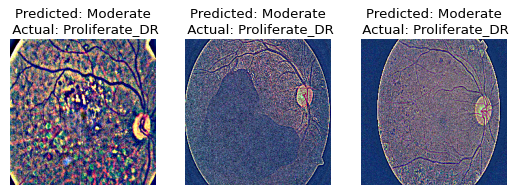

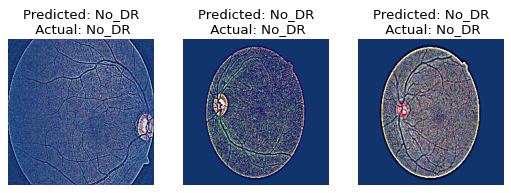

In [ ]:
load_weights()
display_examples(dataset, dataloader, net)

#### Case 3: Unequal Length Data & Unequal Classes

In [ ]:
trainloaders, valloaders=data_splitter([0.3,0.5,0.1,0.05,0.05],[0.1,0.3,0.2,0.2,0.2],[0.05,0.2,0.15,0.5,0.1],[0.1,0.1,0.25,0.35,0.2],[0.3,0.1,0.1,0.1,0.4])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 586
Client 1 - Test Size: 146
Client 2 - Train Size: 1007
Client 2 - Test Size: 146
Client 3 - Train Size: 383
Client 3 - Test Size: 146
Client 4 - Train Size: 606
Client 4 - Test Size: 146
Client 5 - Train Size: 347
Client 5 - Test Size: 149


In [ ]:
net = Net().to(DEVICE)
run_fedAvg()

INFO flwr 2023-04-20 00:23:34,515 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-20 00:23:40,996	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-20 00:23:42,442 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 4004161536.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'memory': 8008323072.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 4004161536.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'memory': 8008323072.0}
INFO flwr 2023-04-20 00:23:42,450 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-20 00:23:42,454 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=48887) Adam (
(launch_and_fit pid=48887) Parameter Group 0
(launch_and_fit pid=48887)     amsgrad: False
(launch_and_fit pid=48887)     betas: (0.9, 0.999)
(launch_and_fit pid=48887)     capturable: False
(launch_and_fit pid=48887)     differentiable: False
(launch_and_fit pid=48887)     eps: 1e-08
(launch_and_fit pid=48887)     foreach: None
(launch_and_fit pid=48887)     fused: None
(launch_and_fit pid=48887)     lr: 0.001
(launch_and_fit pid=48887)     maximize: False
(launch_and_fit pid=48887)     weight_decay: 0
(launch_and_fit pid=48887) )


100%|██████████| 48/48 [00:03<00:00, 13.55it/s]
(launch_and_fit pid=48988) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=48988)   warnings.warn(
(launch_and_fit pid=48988) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=48988)   warnings.warn(msg)


(launch_and_fit pid=48988) Adam (
(launch_and_fit pid=48988) Parameter Group 0
(launch_and_fit pid=48988)     amsgrad: False
(launch_and_fit pid=48988)     betas: (0.9, 0.999)
(launch_and_fit pid=48988)     capturable: False
(launch_and_fit pid=48988)     differentiable: False
(launch_and_fit pid=48988)     eps: 1e-08
(launch_and_fit pid=48988)     foreach: None
(launch_and_fit pid=48988)     fused: None
(launch_and_fit pid=48988)     lr: 0.001
(launch_and_fit pid=48988)     maximize: False
(launch_and_fit pid=48988)     weight_decay: 0
(launch_and_fit pid=48988) )


100%|██████████| 126/126 [00:06<00:00, 18.60it/s]
(launch_and_fit pid=49130) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49130)   warnings.warn(
(launch_and_fit pid=49130) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49130)   warnings.warn(msg)
  0%|          | 0/44 [00:00<?, ?it/s]


(launch_and_fit pid=49130) Adam (
(launch_and_fit pid=49130) Parameter Group 0
(launch_and_fit pid=49130)     amsgrad: False
(launch_and_fit pid=49130)     betas: (0.9, 0.999)
(launch_and_fit pid=49130)     capturable: False
(launch_and_fit pid=49130)     differentiable: False
(launch_and_fit pid=49130)     eps: 1e-08
(launch_and_fit pid=49130)     foreach: None
(launch_and_fit pid=49130)     fused: None
(launch_and_fit pid=49130)     lr: 0.001
(launch_and_fit pid=49130)     maximize: False
(launch_and_fit pid=49130)     weight_decay: 0
(launch_and_fit pid=49130) )


100%|██████████| 44/44 [00:02<00:00, 17.64it/s]
(launch_and_fit pid=49226) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49226)   warnings.warn(
(launch_and_fit pid=49226) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49226)   warnings.warn(msg)


(launch_and_fit pid=49226) Adam (
(launch_and_fit pid=49226) Parameter Group 0
(launch_and_fit pid=49226)     amsgrad: False
(launch_and_fit pid=49226)     betas: (0.9, 0.999)
(launch_and_fit pid=49226)     capturable: False
(launch_and_fit pid=49226)     differentiable: False
(launch_and_fit pid=49226)     eps: 1e-08
(launch_and_fit pid=49226)     foreach: None
(launch_and_fit pid=49226)     fused: None
(launch_and_fit pid=49226)     lr: 0.001
(launch_and_fit pid=49226)     maximize: False
(launch_and_fit pid=49226)     weight_decay: 0
(launch_and_fit pid=49226) )


100%|██████████| 74/74 [00:03<00:00, 19.00it/s]
(launch_and_fit pid=49324) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49324)   warnings.warn(
(launch_and_fit pid=49324) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49324)   warnings.warn(msg)
  0%|          | 0/76 [00:00<?, ?it/s]


(launch_and_fit pid=49324) Adam (
(launch_and_fit pid=49324) Parameter Group 0
(launch_and_fit pid=49324)     amsgrad: False
(launch_and_fit pid=49324)     betas: (0.9, 0.999)
(launch_and_fit pid=49324)     capturable: False
(launch_and_fit pid=49324)     differentiable: False
(launch_and_fit pid=49324)     eps: 1e-08
(launch_and_fit pid=49324)     foreach: None
(launch_and_fit pid=49324)     fused: None
(launch_and_fit pid=49324)     lr: 0.001
(launch_and_fit pid=49324)     maximize: False
(launch_and_fit pid=49324)     weight_decay: 0
(launch_and_fit pid=49324) )


100%|██████████| 76/76 [00:03<00:00, 20.17it/s]
DEBUG flwr 2023-04-20 00:24:34,744 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-20 00:24:37,799 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-04-20 00:24:38,781 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=49459) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=49459)   warnings.warn(
(launch_and_evaluate pid=49459) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=49459)   warnings.warn(msg)


(scheduler +45m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 19/19 [00:01<00:00, 17.80it/s]
(launch_and_evaluate pid=49531) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=49531)   warnings.warn(
(launch_and_evaluate pid=49531) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=49531)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 17.70it/s]
(launch_and_evaluate pid=49595) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecate

(launch_and_fit pid=49799) Adam (
(launch_and_fit pid=49799) Parameter Group 0
(launch_and_fit pid=49799)     amsgrad: False
(launch_and_fit pid=49799)     betas: (0.9, 0.999)
(launch_and_fit pid=49799)     capturable: False
(launch_and_fit pid=49799)     differentiable: False
(launch_and_fit pid=49799)     eps: 1e-08
(launch_and_fit pid=49799)     foreach: None
(launch_and_fit pid=49799)     fused: None
(launch_and_fit pid=49799)     lr: 0.001
(launch_and_fit pid=49799)     maximize: False
(launch_and_fit pid=49799)     weight_decay: 0
(launch_and_fit pid=49799) )


100%|██████████| 76/76 [00:04<00:00, 18.52it/s]
(launch_and_fit pid=49906) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49906)   warnings.warn(
(launch_and_fit pid=49906) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49906)   warnings.warn(msg)
  0%|          | 0/48 [00:00<?, ?it/s]


(launch_and_fit pid=49906) Adam (
(launch_and_fit pid=49906) Parameter Group 0
(launch_and_fit pid=49906)     amsgrad: False
(launch_and_fit pid=49906)     betas: (0.9, 0.999)
(launch_and_fit pid=49906)     capturable: False
(launch_and_fit pid=49906)     differentiable: False
(launch_and_fit pid=49906)     eps: 1e-08
(launch_and_fit pid=49906)     foreach: None
(launch_and_fit pid=49906)     fused: None
(launch_and_fit pid=49906)     lr: 0.001
(launch_and_fit pid=49906)     maximize: False
(launch_and_fit pid=49906)     weight_decay: 0
(launch_and_fit pid=49906) )


100%|██████████| 48/48 [00:02<00:00, 21.21it/s]
(launch_and_fit pid=49994) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49994)   warnings.warn(
(launch_and_fit pid=49994) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49994)   warnings.warn(msg)


(launch_and_fit pid=49994) Adam (
(launch_and_fit pid=49994) Parameter Group 0
(launch_and_fit pid=49994)     amsgrad: False
(launch_and_fit pid=49994)     betas: (0.9, 0.999)
(launch_and_fit pid=49994)     capturable: False
(launch_and_fit pid=49994)     differentiable: False
(launch_and_fit pid=49994)     eps: 1e-08
(launch_and_fit pid=49994)     foreach: None
(launch_and_fit pid=49994)     fused: None
(launch_and_fit pid=49994)     lr: 0.001
(launch_and_fit pid=49994)     maximize: False
(launch_and_fit pid=49994)     weight_decay: 0
(launch_and_fit pid=49994) )


100%|██████████| 126/126 [00:06<00:00, 19.61it/s]
(launch_and_fit pid=50122) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=50122)   warnings.warn(
(launch_and_fit pid=50122) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=50122)   warnings.warn(msg)
  0%|          | 0/44 [00:00<?, ?it/s]


(launch_and_fit pid=50122) Adam (
(launch_and_fit pid=50122) Parameter Group 0
(launch_and_fit pid=50122)     amsgrad: False
(launch_and_fit pid=50122)     betas: (0.9, 0.999)
(launch_and_fit pid=50122)     capturable: False
(launch_and_fit pid=50122)     differentiable: False
(launch_and_fit pid=50122)     eps: 1e-08
(launch_and_fit pid=50122)     foreach: None
(launch_and_fit pid=50122)     fused: None
(launch_and_fit pid=50122)     lr: 0.001
(launch_and_fit pid=50122)     maximize: False
(launch_and_fit pid=50122)     weight_decay: 0
(launch_and_fit pid=50122) )


100%|██████████| 44/44 [00:02<00:00, 21.08it/s]
(launch_and_fit pid=50204) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=50204)   warnings.warn(
(launch_and_fit pid=50204) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=50204)   warnings.warn(msg)


(launch_and_fit pid=50204) Adam (
(launch_and_fit pid=50204) Parameter Group 0
(launch_and_fit pid=50204)     amsgrad: False
(launch_and_fit pid=50204)     betas: (0.9, 0.999)
(launch_and_fit pid=50204)     capturable: False
(launch_and_fit pid=50204)     differentiable: False
(launch_and_fit pid=50204)     eps: 1e-08
(launch_and_fit pid=50204)     foreach: None
(launch_and_fit pid=50204)     fused: None
(launch_and_fit pid=50204)     lr: 0.001
(launch_and_fit pid=50204)     maximize: False
(launch_and_fit pid=50204)     weight_decay: 0
(launch_and_fit pid=50204) )


100%|██████████| 74/74 [00:03<00:00, 19.69it/s]
DEBUG flwr 2023-04-20 00:25:50,891 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-04-20 00:25:56,198 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=50331) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=50331)   warnings.warn(
(launch_and_evaluate pid=50331) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=50331)   warnings.warn(msg)
  0%|          | 0/19 [00:00<?, ?it/s]
(raylet) Spilled 2834 MiB, 29 objects,

(launch_and_fit pid=50804) Adam (
(launch_and_fit pid=50804) Parameter Group 0
(launch_and_fit pid=50804)     amsgrad: False
(launch_and_fit pid=50804)     betas: (0.9, 0.999)
(launch_and_fit pid=50804)     capturable: False
(launch_and_fit pid=50804)     differentiable: False
(launch_and_fit pid=50804)     eps: 1e-08
(launch_and_fit pid=50804)     foreach: None
(launch_and_fit pid=50804)     fused: None
(launch_and_fit pid=50804)     lr: 0.001
(launch_and_fit pid=50804)     maximize: False
(launch_and_fit pid=50804)     weight_decay: 0
(launch_and_fit pid=50804) )


100%|██████████| 126/126 [00:08<00:00, 14.41it/s]
(launch_and_fit pid=50967) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=50967)   warnings.warn(
(launch_and_fit pid=50967) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=50967)   warnings.warn(msg)


(launch_and_fit pid=50967) Adam (
(launch_and_fit pid=50967) Parameter Group 0
(launch_and_fit pid=50967)     amsgrad: False
(launch_and_fit pid=50967)     betas: (0.9, 0.999)
(launch_and_fit pid=50967)     capturable: False
(launch_and_fit pid=50967)     differentiable: False
(launch_and_fit pid=50967)     eps: 1e-08
(launch_and_fit pid=50967)     foreach: None
(launch_and_fit pid=50967)     fused: None
(launch_and_fit pid=50967)     lr: 0.001
(launch_and_fit pid=50967)     maximize: False
(launch_and_fit pid=50967)     weight_decay: 0
(launch_and_fit pid=50967) )


100%|██████████| 74/74 [00:05<00:00, 14.65it/s]
(launch_and_fit pid=51092) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=51092)   warnings.warn(
(launch_and_fit pid=51092) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=51092)   warnings.warn(msg)


(launch_and_fit pid=51092) Adam (
(launch_and_fit pid=51092) Parameter Group 0
(launch_and_fit pid=51092)     amsgrad: False
(launch_and_fit pid=51092)     betas: (0.9, 0.999)
(launch_and_fit pid=51092)     capturable: False
(launch_and_fit pid=51092)     differentiable: False
(launch_and_fit pid=51092)     eps: 1e-08
(launch_and_fit pid=51092)     foreach: None
(launch_and_fit pid=51092)     fused: None
(launch_and_fit pid=51092)     lr: 0.001
(launch_and_fit pid=51092)     maximize: False
(launch_and_fit pid=51092)     weight_decay: 0
(launch_and_fit pid=51092) )


100%|██████████| 48/48 [00:02<00:00, 16.96it/s]
(launch_and_fit pid=51187) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=51187)   warnings.warn(
(launch_and_fit pid=51187) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=51187)   warnings.warn(msg)
  0%|          | 0/76 [00:00<?, ?it/s]


(launch_and_fit pid=51187) Adam (
(launch_and_fit pid=51187) Parameter Group 0
(launch_and_fit pid=51187)     amsgrad: False
(launch_and_fit pid=51187)     betas: (0.9, 0.999)
(launch_and_fit pid=51187)     capturable: False
(launch_and_fit pid=51187)     differentiable: False
(launch_and_fit pid=51187)     eps: 1e-08
(launch_and_fit pid=51187)     foreach: None
(launch_and_fit pid=51187)     fused: None
(launch_and_fit pid=51187)     lr: 0.001
(launch_and_fit pid=51187)     maximize: False
(launch_and_fit pid=51187)     weight_decay: 0
(launch_and_fit pid=51187) )


100%|██████████| 76/76 [00:05<00:00, 15.04it/s]
(launch_and_fit pid=51307) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=51307)   warnings.warn(
(launch_and_fit pid=51307) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=51307)   warnings.warn(msg)


(launch_and_fit pid=51307) Adam (
(launch_and_fit pid=51307) Parameter Group 0
(launch_and_fit pid=51307)     amsgrad: False
(launch_and_fit pid=51307)     betas: (0.9, 0.999)
(launch_and_fit pid=51307)     capturable: False
(launch_and_fit pid=51307)     differentiable: False
(launch_and_fit pid=51307)     eps: 1e-08
(launch_and_fit pid=51307)     foreach: None
(launch_and_fit pid=51307)     fused: None
(launch_and_fit pid=51307)     lr: 0.001
(launch_and_fit pid=51307)     maximize: False
(launch_and_fit pid=51307)     weight_decay: 0
(launch_and_fit pid=51307) )


100%|██████████| 44/44 [00:02<00:00, 16.48it/s]
DEBUG flwr 2023-04-20 00:27:32,309 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-04-20 00:27:38,324 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(raylet) [2023-04-20 00:27:40,932 E 48650 48650] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 04a8329dda4823fb1aa41e45b31a1bf5ab0d7bc845b07f8770171cf5, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the envir

(scheduler +48m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=51442) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=51442)   warnings.warn(
(launch_and_evaluate pid=51442) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=51442)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 11.66it/s]
(launch_and_evaluate pid=51532) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(launch_and_fit pid=51827) Adam (
(launch_and_fit pid=51827) Parameter Group 0
(launch_and_fit pid=51827)     amsgrad: False
(launch_and_fit pid=51827)     betas: (0.9, 0.999)
(launch_and_fit pid=51827)     capturable: False
(launch_and_fit pid=51827)     differentiable: False
(launch_and_fit pid=51827)     eps: 1e-08
(launch_and_fit pid=51827)     foreach: None
(launch_and_fit pid=51827)     fused: None
(launch_and_fit pid=51827)     lr: 0.001
(launch_and_fit pid=51827)     maximize: False
(launch_and_fit pid=51827)     weight_decay: 0
(launch_and_fit pid=51827) )


100%|██████████| 44/44 [00:03<00:00, 12.44it/s]
(launch_and_fit pid=51930) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=51930)   warnings.warn(
(launch_and_fit pid=51930) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=51930)   warnings.warn(msg)


(launch_and_fit pid=51930) Adam (
(launch_and_fit pid=51930) Parameter Group 0
(launch_and_fit pid=51930)     amsgrad: False
(launch_and_fit pid=51930)     betas: (0.9, 0.999)
(launch_and_fit pid=51930)     capturable: False
(launch_and_fit pid=51930)     differentiable: False
(launch_and_fit pid=51930)     eps: 1e-08
(launch_and_fit pid=51930)     foreach: None
(launch_and_fit pid=51930)     fused: None
(launch_and_fit pid=51930)     lr: 0.001
(launch_and_fit pid=51930)     maximize: False
(launch_and_fit pid=51930)     weight_decay: 0
(launch_and_fit pid=51930) )


100%|██████████| 76/76 [00:04<00:00, 17.19it/s]
(launch_and_fit pid=52044) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=52044)   warnings.warn(
(launch_and_fit pid=52044) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=52044)   warnings.warn(msg)
  0%|          | 0/126 [00:00<?, ?it/s]


(launch_and_fit pid=52044) Adam (
(launch_and_fit pid=52044) Parameter Group 0
(launch_and_fit pid=52044)     amsgrad: False
(launch_and_fit pid=52044)     betas: (0.9, 0.999)
(launch_and_fit pid=52044)     capturable: False
(launch_and_fit pid=52044)     differentiable: False
(launch_and_fit pid=52044)     eps: 1e-08
(launch_and_fit pid=52044)     foreach: None
(launch_and_fit pid=52044)     fused: None
(launch_and_fit pid=52044)     lr: 0.001
(launch_and_fit pid=52044)     maximize: False
(launch_and_fit pid=52044)     weight_decay: 0
(launch_and_fit pid=52044) )


100%|██████████| 126/126 [00:06<00:00, 18.17it/s]
(launch_and_fit pid=52188) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=52188)   warnings.warn(
(launch_and_fit pid=52188) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=52188)   warnings.warn(msg)


(launch_and_fit pid=52188) Adam (
(launch_and_fit pid=52188) Parameter Group 0
(launch_and_fit pid=52188)     amsgrad: False
(launch_and_fit pid=52188)     betas: (0.9, 0.999)
(launch_and_fit pid=52188)     capturable: False
(launch_and_fit pid=52188)     differentiable: False
(launch_and_fit pid=52188)     eps: 1e-08
(launch_and_fit pid=52188)     foreach: None
(launch_and_fit pid=52188)     fused: None
(launch_and_fit pid=52188)     lr: 0.001
(launch_and_fit pid=52188)     maximize: False
(launch_and_fit pid=52188)     weight_decay: 0
(launch_and_fit pid=52188) )


100%|██████████| 74/74 [00:05<00:00, 14.59it/s]
(launch_and_fit pid=52307) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=52307)   warnings.warn(
(launch_and_fit pid=52307) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=52307)   warnings.warn(msg)
  0%|          | 0/48 [00:00<?, ?it/s]


(launch_and_fit pid=52307) Adam (
(launch_and_fit pid=52307) Parameter Group 0
(launch_and_fit pid=52307)     amsgrad: False
(launch_and_fit pid=52307)     betas: (0.9, 0.999)
(launch_and_fit pid=52307)     capturable: False
(launch_and_fit pid=52307)     differentiable: False
(launch_and_fit pid=52307)     eps: 1e-08
(launch_and_fit pid=52307)     foreach: None
(launch_and_fit pid=52307)     fused: None
(launch_and_fit pid=52307)     lr: 0.001
(launch_and_fit pid=52307)     maximize: False
(launch_and_fit pid=52307)     weight_decay: 0
(launch_and_fit pid=52307) )


100%|██████████| 48/48 [00:02<00:00, 18.36it/s]
DEBUG flwr 2023-04-20 00:29:03,104 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-04-20 00:29:09,283 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(raylet) Spilled 4143 MiB, 43 objects, write throughput 200 MiB/s.


(scheduler +49m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=52430) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=52430)   warnings.warn(
(launch_and_evaluate pid=52430) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=52430)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  8.03it/s]
(launch_and_evaluate pid=52544) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(launch_and_fit pid=52840) Adam (
(launch_and_fit pid=52840) Parameter Group 0
(launch_and_fit pid=52840)     amsgrad: False
(launch_and_fit pid=52840)     betas: (0.9, 0.999)
(launch_and_fit pid=52840)     capturable: False
(launch_and_fit pid=52840)     differentiable: False
(launch_and_fit pid=52840)     eps: 1e-08
(launch_and_fit pid=52840)     foreach: None
(launch_and_fit pid=52840)     fused: None
(launch_and_fit pid=52840)     lr: 0.001
(launch_and_fit pid=52840)     maximize: False
(launch_and_fit pid=52840)     weight_decay: 0
(launch_and_fit pid=52840) )


100%|██████████| 48/48 [00:03<00:00, 15.07it/s]
(launch_and_fit pid=52941) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=52941)   warnings.warn(
(launch_and_fit pid=52941) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=52941)   warnings.warn(msg)
  0%|          | 0/44 [00:00<?, ?it/s]


(launch_and_fit pid=52941) Adam (
(launch_and_fit pid=52941) Parameter Group 0
(launch_and_fit pid=52941)     amsgrad: False
(launch_and_fit pid=52941)     betas: (0.9, 0.999)
(launch_and_fit pid=52941)     capturable: False
(launch_and_fit pid=52941)     differentiable: False
(launch_and_fit pid=52941)     eps: 1e-08
(launch_and_fit pid=52941)     foreach: None
(launch_and_fit pid=52941)     fused: None
(launch_and_fit pid=52941)     lr: 0.001
(launch_and_fit pid=52941)     maximize: False
(launch_and_fit pid=52941)     weight_decay: 0
(launch_and_fit pid=52941) )


100%|██████████| 44/44 [00:03<00:00, 12.41it/s]
(launch_and_fit pid=53044) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=53044)   warnings.warn(
(launch_and_fit pid=53044) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=53044)   warnings.warn(msg)
  0%|          | 0/76 [00:00<?, ?it/s]


(launch_and_fit pid=53044) Adam (
(launch_and_fit pid=53044) Parameter Group 0
(launch_and_fit pid=53044)     amsgrad: False
(launch_and_fit pid=53044)     betas: (0.9, 0.999)
(launch_and_fit pid=53044)     capturable: False
(launch_and_fit pid=53044)     differentiable: False
(launch_and_fit pid=53044)     eps: 1e-08
(launch_and_fit pid=53044)     foreach: None
(launch_and_fit pid=53044)     fused: None
(launch_and_fit pid=53044)     lr: 0.001
(launch_and_fit pid=53044)     maximize: False
(launch_and_fit pid=53044)     weight_decay: 0
(launch_and_fit pid=53044) )


100%|██████████| 76/76 [00:04<00:00, 17.47it/s]
(launch_and_fit pid=53155) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=53155)   warnings.warn(
(launch_and_fit pid=53155) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=53155)   warnings.warn(msg)


(launch_and_fit pid=53155) Adam (
(launch_and_fit pid=53155) Parameter Group 0
(launch_and_fit pid=53155)     amsgrad: False
(launch_and_fit pid=53155)     betas: (0.9, 0.999)
(launch_and_fit pid=53155)     capturable: False
(launch_and_fit pid=53155)     differentiable: False
(launch_and_fit pid=53155)     eps: 1e-08
(launch_and_fit pid=53155)     foreach: None
(launch_and_fit pid=53155)     fused: None
(launch_and_fit pid=53155)     lr: 0.001
(launch_and_fit pid=53155)     maximize: False
(launch_and_fit pid=53155)     weight_decay: 0
(launch_and_fit pid=53155) )


100%|██████████| 126/126 [00:07<00:00, 15.96it/s]
(launch_and_fit pid=53303) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=53303)   warnings.warn(
(launch_and_fit pid=53303) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=53303)   warnings.warn(msg)


(launch_and_fit pid=53303) Adam (
(launch_and_fit pid=53303) Parameter Group 0
(launch_and_fit pid=53303)     amsgrad: False
(launch_and_fit pid=53303)     betas: (0.9, 0.999)
(launch_and_fit pid=53303)     capturable: False
(launch_and_fit pid=53303)     differentiable: False
(launch_and_fit pid=53303)     eps: 1e-08
(launch_and_fit pid=53303)     foreach: None
(launch_and_fit pid=53303)     fused: None
(launch_and_fit pid=53303)     lr: 0.001
(launch_and_fit pid=53303)     maximize: False
(launch_and_fit pid=53303)     weight_decay: 0
(launch_and_fit pid=53303) )


100%|██████████| 74/74 [00:03<00:00, 18.85it/s]
DEBUG flwr 2023-04-20 00:30:40,021 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-04-20 00:30:47,262 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)


(scheduler +51m34s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=53442) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=53442)   warnings.warn(
(launch_and_evaluate pid=53442) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=53442)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  7.91it/s]
(launch_and_evaluate pid=53553) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

Loading pre-trained model from:  ./model_round_5.pth


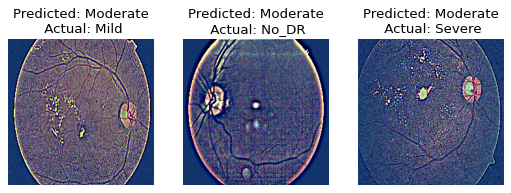

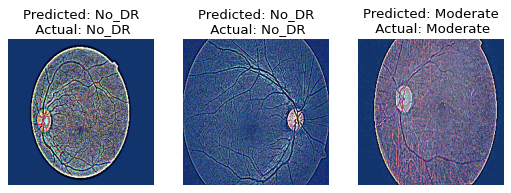

In [ ]:
load_weights()
display_examples(dataset, dataloader, net)

#### Case 4: Unequal Classes
##### Case I: 1 class per client

In [ ]:
trainloaders, valloaders=data_splitter([0.99,0.0025,0.0025,0.0025,0.0025],[0.0025,0.99,0.0025,0.0025,0.0025],[0.0025,0.0025,0.99,0.0025,0.0025],[0.0025,0.0025,0.0025,0.99,0.0025],[0.0025,0.0025,0.0025,0.0025,0.99])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 1430
Client 1 - Test Size: 146
Client 2 - Train Size: 297
Client 2 - Test Size: 146
Client 3 - Train Size: 794
Client 3 - Test Size: 146
Client 4 - Train Size: 156
Client 4 - Test Size: 146
Client 5 - Train Size: 252
Client 5 - Test Size: 149


In [ ]:
net = Net().to(DEVICE)
run_fedAvg()

INFO flwr 2023-04-20 00:37:03,352 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-20 00:37:09,681	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-20 00:37:11,948 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 8012260148.0, 'CPU': 2.0, 'object_store_memory': 4006130073.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 8012260148.0, 'CPU': 2.0, 'object_store_memory': 4006130073.0, 'GPU': 1.0}
INFO flwr 2023-04-20 00:37:11,955 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-20 00:37:11,960 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=55657) Adam (
(launch_and_fit pid=55657) Parameter Group 0
(launch_and_fit pid=55657)     amsgrad: False
(launch_and_fit pid=55657)     betas: (0.9, 0.999)
(launch_and_fit pid=55657)     capturable: False
(launch_and_fit pid=55657)     differentiable: False
(launch_and_fit pid=55657)     eps: 1e-08
(launch_and_fit pid=55657)     foreach: None
(launch_and_fit pid=55657)     fused: None
(launch_and_fit pid=55657)     lr: 0.001
(launch_and_fit pid=55657)     maximize: False
(launch_and_fit pid=55657)     weight_decay: 0
(launch_and_fit pid=55657) )


100%|██████████| 179/179 [00:10<00:00, 17.00it/s]
(launch_and_fit pid=55842) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=55842)   warnings.warn(
(launch_and_fit pid=55842) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=55842)   warnings.warn(msg)
  0%|          | 0/20 [00:00<?, ?it/s]


(launch_and_fit pid=55842) Adam (
(launch_and_fit pid=55842) Parameter Group 0
(launch_and_fit pid=55842)     amsgrad: False
(launch_and_fit pid=55842)     betas: (0.9, 0.999)
(launch_and_fit pid=55842)     capturable: False
(launch_and_fit pid=55842)     differentiable: False
(launch_and_fit pid=55842)     eps: 1e-08
(launch_and_fit pid=55842)     foreach: None
(launch_and_fit pid=55842)     fused: None
(launch_and_fit pid=55842)     lr: 0.001
(launch_and_fit pid=55842)     maximize: False
(launch_and_fit pid=55842)     weight_decay: 0
(launch_and_fit pid=55842) )


100%|██████████| 20/20 [00:01<00:00, 15.70it/s]
(launch_and_fit pid=55916) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=55916)   warnings.warn(
(launch_and_fit pid=55916) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=55916)   warnings.warn(msg)


(launch_and_fit pid=55916) Adam (
(launch_and_fit pid=55916) Parameter Group 0
(launch_and_fit pid=55916)     amsgrad: False
(launch_and_fit pid=55916)     betas: (0.9, 0.999)
(launch_and_fit pid=55916)     capturable: False
(launch_and_fit pid=55916)     differentiable: False
(launch_and_fit pid=55916)     eps: 1e-08
(launch_and_fit pid=55916)     foreach: None
(launch_and_fit pid=55916)     fused: None
(launch_and_fit pid=55916)     lr: 0.001
(launch_and_fit pid=55916)     maximize: False
(launch_and_fit pid=55916)     weight_decay: 0
(launch_and_fit pid=55916) )


100%|██████████| 100/100 [00:05<00:00, 17.33it/s]
(launch_and_fit pid=56041) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=56041)   warnings.warn(
(launch_and_fit pid=56041) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=56041)   warnings.warn(msg)
  0%|          | 0/38 [00:00<?, ?it/s]


(launch_and_fit pid=56041) Adam (
(launch_and_fit pid=56041) Parameter Group 0
(launch_and_fit pid=56041)     amsgrad: False
(launch_and_fit pid=56041)     betas: (0.9, 0.999)
(launch_and_fit pid=56041)     capturable: False
(launch_and_fit pid=56041)     differentiable: False
(launch_and_fit pid=56041)     eps: 1e-08
(launch_and_fit pid=56041)     foreach: None
(launch_and_fit pid=56041)     fused: None
(launch_and_fit pid=56041)     lr: 0.001
(launch_and_fit pid=56041)     maximize: False
(launch_and_fit pid=56041)     weight_decay: 0
(launch_and_fit pid=56041) )


  8%|▊         | 3/38 [00:00<00:03,  9.00it/s]


(scheduler +58m36s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 38/38 [00:02<00:00, 18.16it/s]
(launch_and_fit pid=56119) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=56119)   warnings.warn(
(launch_and_fit pid=56119) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=56119)   warnings.warn(msg)
  0%|          | 0/32 [00:00<?, ?it/s]


(launch_and_fit pid=56119) Adam (
(launch_and_fit pid=56119) Parameter Group 0
(launch_and_fit pid=56119)     amsgrad: False
(launch_and_fit pid=56119)     betas: (0.9, 0.999)
(launch_and_fit pid=56119)     capturable: False
(launch_and_fit pid=56119)     differentiable: False
(launch_and_fit pid=56119)     eps: 1e-08
(launch_and_fit pid=56119)     foreach: None
(launch_and_fit pid=56119)     fused: None
(launch_and_fit pid=56119)     lr: 0.001
(launch_and_fit pid=56119)     maximize: False
(launch_and_fit pid=56119)     weight_decay: 0
(launch_and_fit pid=56119) )


100%|██████████| 32/32 [00:02<00:00, 13.93it/s]
DEBUG flwr 2023-04-20 00:38:04,230 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-20 00:38:07,357 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-04-20 00:38:08,321 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=56240) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=56240)   warnings.warn(
(launch_and_evaluate pid=56240) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=56240)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 16.54it/s]
(launch_and_evaluate pid=5630

(launch_and_fit pid=56586) Adam (
(launch_and_fit pid=56586) Parameter Group 0
(launch_and_fit pid=56586)     amsgrad: False
(launch_and_fit pid=56586)     betas: (0.9, 0.999)
(launch_and_fit pid=56586)     capturable: False
(launch_and_fit pid=56586)     differentiable: False
(launch_and_fit pid=56586)     eps: 1e-08
(launch_and_fit pid=56586)     foreach: None
(launch_and_fit pid=56586)     fused: None
(launch_and_fit pid=56586)     lr: 0.001
(launch_and_fit pid=56586)     maximize: False
(launch_and_fit pid=56586)     weight_decay: 0
(launch_and_fit pid=56586) )


100%|██████████| 100/100 [00:04<00:00, 22.40it/s]
(launch_and_fit pid=56696) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=56696)   warnings.warn(
(launch_and_fit pid=56696) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=56696)   warnings.warn(msg)


(launch_and_fit pid=56696) Adam (
(launch_and_fit pid=56696) Parameter Group 0
(launch_and_fit pid=56696)     amsgrad: False
(launch_and_fit pid=56696)     betas: (0.9, 0.999)
(launch_and_fit pid=56696)     capturable: False
(launch_and_fit pid=56696)     differentiable: False
(launch_and_fit pid=56696)     eps: 1e-08
(launch_and_fit pid=56696)     foreach: None
(launch_and_fit pid=56696)     fused: None
(launch_and_fit pid=56696)     lr: 0.001
(launch_and_fit pid=56696)     maximize: False
(launch_and_fit pid=56696)     weight_decay: 0
(launch_and_fit pid=56696) )


100%|██████████| 179/179 [00:07<00:00, 22.42it/s]
(launch_and_fit pid=56854) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=56854)   warnings.warn(
(launch_and_fit pid=56854) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=56854)   warnings.warn(msg)
  0%|          | 0/38 [00:00<?, ?it/s]


(launch_and_fit pid=56854) Adam (
(launch_and_fit pid=56854) Parameter Group 0
(launch_and_fit pid=56854)     amsgrad: False
(launch_and_fit pid=56854)     betas: (0.9, 0.999)
(launch_and_fit pid=56854)     capturable: False
(launch_and_fit pid=56854)     differentiable: False
(launch_and_fit pid=56854)     eps: 1e-08
(launch_and_fit pid=56854)     foreach: None
(launch_and_fit pid=56854)     fused: None
(launch_and_fit pid=56854)     lr: 0.001
(launch_and_fit pid=56854)     maximize: False
(launch_and_fit pid=56854)     weight_decay: 0
(launch_and_fit pid=56854) )


100%|██████████| 38/38 [00:02<00:00, 16.71it/s]
(launch_and_fit pid=56939) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=56939)   warnings.warn(
(launch_and_fit pid=56939) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=56939)   warnings.warn(msg)


(launch_and_fit pid=56939) Adam (
(launch_and_fit pid=56939) Parameter Group 0
(launch_and_fit pid=56939)     amsgrad: False
(launch_and_fit pid=56939)     betas: (0.9, 0.999)
(launch_and_fit pid=56939)     capturable: False
(launch_and_fit pid=56939)     differentiable: False
(launch_and_fit pid=56939)     eps: 1e-08
(launch_and_fit pid=56939)     foreach: None
(launch_and_fit pid=56939)     fused: None
(launch_and_fit pid=56939)     lr: 0.001
(launch_and_fit pid=56939)     maximize: False
(launch_and_fit pid=56939)     weight_decay: 0
(launch_and_fit pid=56939) )


100%|██████████| 20/20 [00:01<00:00, 18.51it/s]
(launch_and_fit pid=57013) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=57013)   warnings.warn(
(launch_and_fit pid=57013) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=57013)   warnings.warn(msg)
  0%|          | 0/32 [00:00<?, ?it/s]


(launch_and_fit pid=57013) Adam (
(launch_and_fit pid=57013) Parameter Group 0
(launch_and_fit pid=57013)     amsgrad: False
(launch_and_fit pid=57013)     betas: (0.9, 0.999)
(launch_and_fit pid=57013)     capturable: False
(launch_and_fit pid=57013)     differentiable: False
(launch_and_fit pid=57013)     eps: 1e-08
(launch_and_fit pid=57013)     foreach: None
(launch_and_fit pid=57013)     fused: None
(launch_and_fit pid=57013)     lr: 0.001
(launch_and_fit pid=57013)     maximize: False
(launch_and_fit pid=57013)     weight_decay: 0
(launch_and_fit pid=57013) )


100%|██████████| 32/32 [00:01<00:00, 20.27it/s]
DEBUG flwr 2023-04-20 00:39:20,400 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-04-20 00:39:26,178 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=57122) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=57122)   warnings.warn(
(launch_and_evaluate pid=57122) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=57122)   warnings.warn(msg)
(raylet) Spilled 3052 MiB, 30 objects, write throughput 211 MiB/s. Set RAY_ve

(launch_and_fit pid=57651) Adam (
(launch_and_fit pid=57651) Parameter Group 0
(launch_and_fit pid=57651)     amsgrad: False
(launch_and_fit pid=57651)     betas: (0.9, 0.999)
(launch_and_fit pid=57651)     capturable: False
(launch_and_fit pid=57651)     differentiable: False
(launch_and_fit pid=57651)     eps: 1e-08
(launch_and_fit pid=57651)     foreach: None
(launch_and_fit pid=57651)     fused: None
(launch_and_fit pid=57651)     lr: 0.001
(launch_and_fit pid=57651)     maximize: False
(launch_and_fit pid=57651)     weight_decay: 0
(launch_and_fit pid=57651) )


100%|██████████| 38/38 [00:03<00:00, 12.39it/s]
(raylet) Spilled 4142 MiB, 40 objects, write throughput 209 MiB/s.
(launch_and_fit pid=57758) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=57758)   warnings.warn(
(launch_and_fit pid=57758) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=57758)   warnings.warn(msg)


(launch_and_fit pid=57758) Adam (
(launch_and_fit pid=57758) Parameter Group 0
(launch_and_fit pid=57758)     amsgrad: False
(launch_and_fit pid=57758)     betas: (0.9, 0.999)
(launch_and_fit pid=57758)     capturable: False
(launch_and_fit pid=57758)     differentiable: False
(launch_and_fit pid=57758)     eps: 1e-08
(launch_and_fit pid=57758)     foreach: None
(launch_and_fit pid=57758)     fused: None
(launch_and_fit pid=57758)     lr: 0.001
(launch_and_fit pid=57758)     maximize: False
(launch_and_fit pid=57758)     weight_decay: 0
(launch_and_fit pid=57758) )


100%|██████████| 32/32 [00:02<00:00, 15.93it/s]
(launch_and_fit pid=57845) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=57845)   warnings.warn(
(launch_and_fit pid=57845) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=57845)   warnings.warn(msg)
  0%|          | 0/179 [00:00<?, ?it/s]


(launch_and_fit pid=57845) Adam (
(launch_and_fit pid=57845) Parameter Group 0
(launch_and_fit pid=57845)     amsgrad: False
(launch_and_fit pid=57845)     betas: (0.9, 0.999)
(launch_and_fit pid=57845)     capturable: False
(launch_and_fit pid=57845)     differentiable: False
(launch_and_fit pid=57845)     eps: 1e-08
(launch_and_fit pid=57845)     foreach: None
(launch_and_fit pid=57845)     fused: None
(launch_and_fit pid=57845)     lr: 0.001
(launch_and_fit pid=57845)     maximize: False
(launch_and_fit pid=57845)     weight_decay: 0
(launch_and_fit pid=57845) )


100%|██████████| 179/179 [00:11<00:00, 15.00it/s]
(launch_and_fit pid=58044) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=58044)   warnings.warn(
(launch_and_fit pid=58044) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=58044)   warnings.warn(msg)


(launch_and_fit pid=58044) Adam (
(launch_and_fit pid=58044) Parameter Group 0
(launch_and_fit pid=58044)     amsgrad: False
(launch_and_fit pid=58044)     betas: (0.9, 0.999)
(launch_and_fit pid=58044)     capturable: False
(launch_and_fit pid=58044)     differentiable: False
(launch_and_fit pid=58044)     eps: 1e-08
(launch_and_fit pid=58044)     foreach: None
(launch_and_fit pid=58044)     fused: None
(launch_and_fit pid=58044)     lr: 0.001
(launch_and_fit pid=58044)     maximize: False
(launch_and_fit pid=58044)     weight_decay: 0
(launch_and_fit pid=58044) )


100%|██████████| 20/20 [00:01<00:00, 15.43it/s]
(launch_and_fit pid=58113) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=58113)   warnings.warn(
(launch_and_fit pid=58113) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=58113)   warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]


(launch_and_fit pid=58113) Adam (
(launch_and_fit pid=58113) Parameter Group 0
(launch_and_fit pid=58113)     amsgrad: False
(launch_and_fit pid=58113)     betas: (0.9, 0.999)
(launch_and_fit pid=58113)     capturable: False
(launch_and_fit pid=58113)     differentiable: False
(launch_and_fit pid=58113)     eps: 1e-08
(launch_and_fit pid=58113)     foreach: None
(launch_and_fit pid=58113)     fused: None
(launch_and_fit pid=58113)     lr: 0.001
(launch_and_fit pid=58113)     maximize: False
(launch_and_fit pid=58113)     weight_decay: 0
(launch_and_fit pid=58113) )


100%|██████████| 100/100 [00:05<00:00, 17.30it/s]
DEBUG flwr 2023-04-20 00:41:03,568 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-04-20 00:41:09,434 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(raylet) [2023-04-20 00:41:09,544 E 55421 55421] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 3a914e44d87bf6271c5c79b6fe6a1a009344c6c7ed4ac113bc6f1db8, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the envir

(launch_and_fit pid=58665) Adam (
(launch_and_fit pid=58665) Parameter Group 0
(launch_and_fit pid=58665)     amsgrad: False
(launch_and_fit pid=58665)     betas: (0.9, 0.999)
(launch_and_fit pid=58665)     capturable: False
(launch_and_fit pid=58665)     differentiable: False
(launch_and_fit pid=58665)     eps: 1e-08
(launch_and_fit pid=58665)     foreach: None
(launch_and_fit pid=58665)     fused: None
(launch_and_fit pid=58665)     lr: 0.001
(launch_and_fit pid=58665)     maximize: False
(launch_and_fit pid=58665)     weight_decay: 0
(launch_and_fit pid=58665) )


100%|██████████| 179/179 [00:10<00:00, 17.16it/s]
(launch_and_fit pid=58856) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=58856)   warnings.warn(
(launch_and_fit pid=58856) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=58856)   warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]


(launch_and_fit pid=58856) Adam (
(launch_and_fit pid=58856) Parameter Group 0
(launch_and_fit pid=58856)     amsgrad: False
(launch_and_fit pid=58856)     betas: (0.9, 0.999)
(launch_and_fit pid=58856)     capturable: False
(launch_and_fit pid=58856)     differentiable: False
(launch_and_fit pid=58856)     eps: 1e-08
(launch_and_fit pid=58856)     foreach: None
(launch_and_fit pid=58856)     fused: None
(launch_and_fit pid=58856)     lr: 0.001
(launch_and_fit pid=58856)     maximize: False
(launch_and_fit pid=58856)     weight_decay: 0
(launch_and_fit pid=58856) )


100%|██████████| 100/100 [00:05<00:00, 18.18it/s]
(launch_and_fit pid=58986) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=58986)   warnings.warn(
(launch_and_fit pid=58986) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=58986)   warnings.warn(msg)
  0%|          | 0/38 [00:00<?, ?it/s]


(launch_and_fit pid=58986) Adam (
(launch_and_fit pid=58986) Parameter Group 0
(launch_and_fit pid=58986)     amsgrad: False
(launch_and_fit pid=58986)     betas: (0.9, 0.999)
(launch_and_fit pid=58986)     capturable: False
(launch_and_fit pid=58986)     differentiable: False
(launch_and_fit pid=58986)     eps: 1e-08
(launch_and_fit pid=58986)     foreach: None
(launch_and_fit pid=58986)     fused: None
(launch_and_fit pid=58986)     lr: 0.001
(launch_and_fit pid=58986)     maximize: False
(launch_and_fit pid=58986)     weight_decay: 0
(launch_and_fit pid=58986) )


100%|██████████| 38/38 [00:02<00:00, 16.33it/s]
(launch_and_fit pid=59073) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=59073)   warnings.warn(
(launch_and_fit pid=59073) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=59073)   warnings.warn(msg)


(launch_and_fit pid=59073) Adam (
(launch_and_fit pid=59073) Parameter Group 0
(launch_and_fit pid=59073)     amsgrad: False
(launch_and_fit pid=59073)     betas: (0.9, 0.999)
(launch_and_fit pid=59073)     capturable: False
(launch_and_fit pid=59073)     differentiable: False
(launch_and_fit pid=59073)     eps: 1e-08
(launch_and_fit pid=59073)     foreach: None
(launch_and_fit pid=59073)     fused: None
(launch_and_fit pid=59073)     lr: 0.001
(launch_and_fit pid=59073)     maximize: False
(launch_and_fit pid=59073)     weight_decay: 0
(launch_and_fit pid=59073) )


100%|██████████| 20/20 [00:01<00:00, 17.40it/s]
(launch_and_fit pid=59152) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=59152)   warnings.warn(
(launch_and_fit pid=59152) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=59152)   warnings.warn(msg)


(launch_and_fit pid=59152) Adam (
(launch_and_fit pid=59152) Parameter Group 0
(launch_and_fit pid=59152)     amsgrad: False
(launch_and_fit pid=59152)     betas: (0.9, 0.999)
(launch_and_fit pid=59152)     capturable: False
(launch_and_fit pid=59152)     differentiable: False
(launch_and_fit pid=59152)     eps: 1e-08
(launch_and_fit pid=59152)     foreach: None
(launch_and_fit pid=59152)     fused: None
(launch_and_fit pid=59152)     lr: 0.001
(launch_and_fit pid=59152)     maximize: False
(launch_and_fit pid=59152)     weight_decay: 0
(launch_and_fit pid=59152) )


100%|██████████| 32/32 [00:01<00:00, 16.40it/s]
DEBUG flwr 2023-04-20 00:42:35,522 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-04-20 00:42:42,703 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)


(scheduler +1h3m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=59272) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=59272)   warnings.warn(
(launch_and_evaluate pid=59272) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=59272)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 10.18it/s]
(launch_and_evaluate pid=59400) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(scheduler +1h4m17s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_fit pid=59712) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=59712)   warnings.warn(
(launch_and_fit pid=59712) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=59712)   warnings.warn(msg)


(launch_and_fit pid=59712) Adam (
(launch_and_fit pid=59712) Parameter Group 0
(launch_and_fit pid=59712)     amsgrad: False
(launch_and_fit pid=59712)     betas: (0.9, 0.999)
(launch_and_fit pid=59712)     capturable: False
(launch_and_fit pid=59712)     differentiable: False
(launch_and_fit pid=59712)     eps: 1e-08
(launch_and_fit pid=59712)     foreach: None
(launch_and_fit pid=59712)     fused: None
(launch_and_fit pid=59712)     lr: 0.001
(launch_and_fit pid=59712)     maximize: False
(launch_and_fit pid=59712)     weight_decay: 0
(launch_and_fit pid=59712) )


100%|██████████| 20/20 [00:01<00:00, 12.56it/s]
(launch_and_fit pid=59804) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=59804)   warnings.warn(
(launch_and_fit pid=59804) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=59804)   warnings.warn(msg)


(launch_and_fit pid=59804) Adam (
(launch_and_fit pid=59804) Parameter Group 0
(launch_and_fit pid=59804)     amsgrad: False
(launch_and_fit pid=59804)     betas: (0.9, 0.999)
(launch_and_fit pid=59804)     capturable: False
(launch_and_fit pid=59804)     differentiable: False
(launch_and_fit pid=59804)     eps: 1e-08
(launch_and_fit pid=59804)     foreach: None
(launch_and_fit pid=59804)     fused: None
(launch_and_fit pid=59804)     lr: 0.001
(launch_and_fit pid=59804)     maximize: False
(launch_and_fit pid=59804)     weight_decay: 0
(launch_and_fit pid=59804) )


100%|██████████| 38/38 [00:02<00:00, 12.95it/s]
(launch_and_fit pid=59905) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=59905)   warnings.warn(
(launch_and_fit pid=59905) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=59905)   warnings.warn(msg)


(launch_and_fit pid=59905) Adam (
(launch_and_fit pid=59905) Parameter Group 0
(launch_and_fit pid=59905)     amsgrad: False
(launch_and_fit pid=59905)     betas: (0.9, 0.999)
(launch_and_fit pid=59905)     capturable: False
(launch_and_fit pid=59905)     differentiable: False
(launch_and_fit pid=59905)     eps: 1e-08
(launch_and_fit pid=59905)     foreach: None
(launch_and_fit pid=59905)     fused: None
(launch_and_fit pid=59905)     lr: 0.001
(launch_and_fit pid=59905)     maximize: False
(launch_and_fit pid=59905)     weight_decay: 0
(launch_and_fit pid=59905) )


100%|██████████| 179/179 [00:12<00:00, 14.20it/s]
(launch_and_fit pid=60110) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=60110)   warnings.warn(
(launch_and_fit pid=60110) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=60110)   warnings.warn(msg)


(launch_and_fit pid=60110) Adam (
(launch_and_fit pid=60110) Parameter Group 0
(launch_and_fit pid=60110)     amsgrad: False
(launch_and_fit pid=60110)     betas: (0.9, 0.999)
(launch_and_fit pid=60110)     capturable: False
(launch_and_fit pid=60110)     differentiable: False
(launch_and_fit pid=60110)     eps: 1e-08
(launch_and_fit pid=60110)     foreach: None
(launch_and_fit pid=60110)     fused: None
(launch_and_fit pid=60110)     lr: 0.001
(launch_and_fit pid=60110)     maximize: False
(launch_and_fit pid=60110)     weight_decay: 0
(launch_and_fit pid=60110) )


100%|██████████| 32/32 [00:02<00:00, 15.71it/s]
(launch_and_fit pid=60193) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=60193)   warnings.warn(
(launch_and_fit pid=60193) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=60193)   warnings.warn(msg)


(launch_and_fit pid=60193) Adam (
(launch_and_fit pid=60193) Parameter Group 0
(launch_and_fit pid=60193)     amsgrad: False
(launch_and_fit pid=60193)     betas: (0.9, 0.999)
(launch_and_fit pid=60193)     capturable: False
(launch_and_fit pid=60193)     differentiable: False
(launch_and_fit pid=60193)     eps: 1e-08
(launch_and_fit pid=60193)     foreach: None
(launch_and_fit pid=60193)     fused: None
(launch_and_fit pid=60193)     lr: 0.001
(launch_and_fit pid=60193)     maximize: False
(launch_and_fit pid=60193)     weight_decay: 0
(launch_and_fit pid=60193) )


100%|██████████| 100/100 [00:06<00:00, 15.34it/s]
DEBUG flwr 2023-04-20 00:44:26,653 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-04-20 00:44:32,768 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=60372) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=60372)   warnings.warn(
(launch_and_evaluate pid=60372) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=60372)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  7.84it/s]
(launch_and_evaluate pid=6047

Loading pre-trained model from:  ./model_round_5.pth


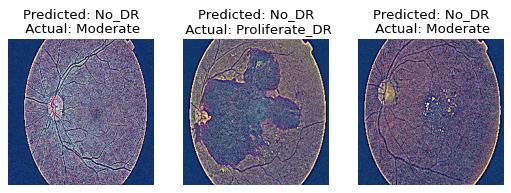

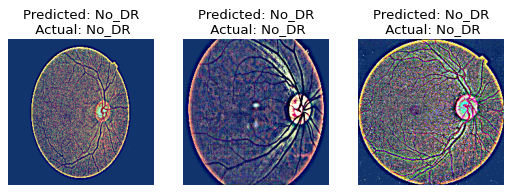

In [ ]:
load_weights()
display_examples(dataset, dataloader, net)

##### Case II: 2 class per client

In [ ]:
trainloaders, valloaders=data_splitter([0.49,0.01,0.01,0.01,0.48],[0.48,0.49,0.01,0.01,0.01],[0.01,0.48,0.49,0.01,0.01],[0.01,0.01,0.48,0.49,0.01],[0.01,0.01,0.01,0.48,0.49])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 859
Client 1 - Test Size: 146
Client 2 - Train Size: 545
Client 2 - Test Size: 146
Client 3 - Train Size: 482
Client 3 - Test Size: 146
Client 4 - Train Size: 211
Client 4 - Test Size: 146
Client 5 - Train Size: 832
Client 5 - Test Size: 149


In [ ]:
net = Net().to(DEVICE)
run_fedAvg()

INFO flwr 2023-04-20 00:46:13,242 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-20 00:46:18,922	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-20 00:46:20,403 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4007258112.0, 'CPU': 2.0, 'GPU': 1.0, 'memory': 8014516224.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 4007258112.0, 'CPU': 2.0, 'GPU': 1.0, 'memory': 8014516224.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-04-20 00:46:20,408 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-20 00:46:20,419 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=61411) Adam (
(launch_and_fit pid=61411) Parameter Group 0
(launch_and_fit pid=61411)     amsgrad: False
(launch_and_fit pid=61411)     betas: (0.9, 0.999)
(launch_and_fit pid=61411)     capturable: False
(launch_and_fit pid=61411)     differentiable: False
(launch_and_fit pid=61411)     eps: 1e-08
(launch_and_fit pid=61411)     foreach: None
(launch_and_fit pid=61411)     fused: None
(launch_and_fit pid=61411)     lr: 0.001
(launch_and_fit pid=61411)     maximize: False
(launch_and_fit pid=61411)     weight_decay: 0
(launch_and_fit pid=61411) )


100%|██████████| 104/104 [00:05<00:00, 17.95it/s]
(launch_and_fit pid=61548) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=61548)   warnings.warn(
(launch_and_fit pid=61548) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=61548)   warnings.warn(msg)


(launch_and_fit pid=61548) Adam (
(launch_and_fit pid=61548) Parameter Group 0
(launch_and_fit pid=61548)     amsgrad: False
(launch_and_fit pid=61548)     betas: (0.9, 0.999)
(launch_and_fit pid=61548)     capturable: False
(launch_and_fit pid=61548)     differentiable: False
(launch_and_fit pid=61548)     eps: 1e-08
(launch_and_fit pid=61548)     foreach: None
(launch_and_fit pid=61548)     fused: None
(launch_and_fit pid=61548)     lr: 0.001
(launch_and_fit pid=61548)     maximize: False
(launch_and_fit pid=61548)     weight_decay: 0
(launch_and_fit pid=61548) )


100%|██████████| 69/69 [00:04<00:00, 15.19it/s]
(launch_and_fit pid=61661) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=61661)   warnings.warn(
(launch_and_fit pid=61661) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=61661)   warnings.warn(msg)
  0%|          | 0/61 [00:00<?, ?it/s]


(launch_and_fit pid=61661) Adam (
(launch_and_fit pid=61661) Parameter Group 0
(launch_and_fit pid=61661)     amsgrad: False
(launch_and_fit pid=61661)     betas: (0.9, 0.999)
(launch_and_fit pid=61661)     capturable: False
(launch_and_fit pid=61661)     differentiable: False
(launch_and_fit pid=61661)     eps: 1e-08
(launch_and_fit pid=61661)     foreach: None
(launch_and_fit pid=61661)     fused: None
(launch_and_fit pid=61661)     lr: 0.001
(launch_and_fit pid=61661)     maximize: False
(launch_and_fit pid=61661)     weight_decay: 0
(launch_and_fit pid=61661) )


100%|██████████| 61/61 [00:03<00:00, 19.12it/s]
(launch_and_fit pid=61751) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=61751)   warnings.warn(
(launch_and_fit pid=61751) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=61751)   warnings.warn(msg)
  0%|          | 0/108 [00:00<?, ?it/s]


(launch_and_fit pid=61751) Adam (
(launch_and_fit pid=61751) Parameter Group 0
(launch_and_fit pid=61751)     amsgrad: False
(launch_and_fit pid=61751)     betas: (0.9, 0.999)
(launch_and_fit pid=61751)     capturable: False
(launch_and_fit pid=61751)     differentiable: False
(launch_and_fit pid=61751)     eps: 1e-08
(launch_and_fit pid=61751)     foreach: None
(launch_and_fit pid=61751)     fused: None
(launch_and_fit pid=61751)     lr: 0.001
(launch_and_fit pid=61751)     maximize: False
(launch_and_fit pid=61751)     weight_decay: 0
(launch_and_fit pid=61751) )


100%|██████████| 108/108 [00:05<00:00, 18.35it/s]
(launch_and_fit pid=61883) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=61883)   warnings.warn(
(launch_and_fit pid=61883) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=61883)   warnings.warn(msg)


(launch_and_fit pid=61883) Adam (
(launch_and_fit pid=61883) Parameter Group 0
(launch_and_fit pid=61883)     amsgrad: False
(launch_and_fit pid=61883)     betas: (0.9, 0.999)
(launch_and_fit pid=61883)     capturable: False
(launch_and_fit pid=61883)     differentiable: False
(launch_and_fit pid=61883)     eps: 1e-08
(launch_and_fit pid=61883)     foreach: None
(launch_and_fit pid=61883)     fused: None
(launch_and_fit pid=61883)     lr: 0.001
(launch_and_fit pid=61883)     maximize: False
(launch_and_fit pid=61883)     weight_decay: 0
(launch_and_fit pid=61883) )


100%|██████████| 27/27 [00:01<00:00, 18.26it/s]
DEBUG flwr 2023-04-20 00:47:12,297 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-20 00:47:15,474 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-04-20 00:47:16,634 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=61989) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=61989)   warnings.warn(
(launch_and_evaluate pid=61989) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=61989)   warnings.warn(msg)
  0%|          | 0/19 [00:00<?, ?it/s]


(scheduler +1h8m5s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 19/19 [00:01<00:00, 17.17it/s]
(launch_and_evaluate pid=62053) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=62053)   warnings.warn(
(launch_and_evaluate pid=62053) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=62053)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 18.69it/s]
(launch_and_evaluate pid=62117) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecate

(launch_and_fit pid=62323) Adam (
(launch_and_fit pid=62323) Parameter Group 0
(launch_and_fit pid=62323)     amsgrad: False
(launch_and_fit pid=62323)     betas: (0.9, 0.999)
(launch_and_fit pid=62323)     capturable: False
(launch_and_fit pid=62323)     differentiable: False
(launch_and_fit pid=62323)     eps: 1e-08
(launch_and_fit pid=62323)     foreach: None
(launch_and_fit pid=62323)     fused: None
(launch_and_fit pid=62323)     lr: 0.001
(launch_and_fit pid=62323)     maximize: False
(launch_and_fit pid=62323)     weight_decay: 0
(launch_and_fit pid=62323) )


100%|██████████| 104/104 [00:05<00:00, 20.06it/s]
(launch_and_fit pid=62446) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=62446)   warnings.warn(
(launch_and_fit pid=62446) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=62446)   warnings.warn(msg)
  0%|          | 0/69 [00:00<?, ?it/s]


(launch_and_fit pid=62446) Adam (
(launch_and_fit pid=62446) Parameter Group 0
(launch_and_fit pid=62446)     amsgrad: False
(launch_and_fit pid=62446)     betas: (0.9, 0.999)
(launch_and_fit pid=62446)     capturable: False
(launch_and_fit pid=62446)     differentiable: False
(launch_and_fit pid=62446)     eps: 1e-08
(launch_and_fit pid=62446)     foreach: None
(launch_and_fit pid=62446)     fused: None
(launch_and_fit pid=62446)     lr: 0.001
(launch_and_fit pid=62446)     maximize: False
(launch_and_fit pid=62446)     weight_decay: 0
(launch_and_fit pid=62446) )


100%|██████████| 69/69 [00:03<00:00, 21.31it/s]
(launch_and_fit pid=62536) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=62536)   warnings.warn(
(launch_and_fit pid=62536) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=62536)   warnings.warn(msg)
  0%|          | 0/61 [00:00<?, ?it/s]


(launch_and_fit pid=62536) Adam (
(launch_and_fit pid=62536) Parameter Group 0
(launch_and_fit pid=62536)     amsgrad: False
(launch_and_fit pid=62536)     betas: (0.9, 0.999)
(launch_and_fit pid=62536)     capturable: False
(launch_and_fit pid=62536)     differentiable: False
(launch_and_fit pid=62536)     eps: 1e-08
(launch_and_fit pid=62536)     foreach: None
(launch_and_fit pid=62536)     fused: None
(launch_and_fit pid=62536)     lr: 0.001
(launch_and_fit pid=62536)     maximize: False
(launch_and_fit pid=62536)     weight_decay: 0
(launch_and_fit pid=62536) )


100%|██████████| 61/61 [00:03<00:00, 19.58it/s]
(launch_and_fit pid=62640) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=62640)   warnings.warn(
(launch_and_fit pid=62640) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=62640)   warnings.warn(msg)


(launch_and_fit pid=62640) Adam (
(launch_and_fit pid=62640) Parameter Group 0
(launch_and_fit pid=62640)     amsgrad: False
(launch_and_fit pid=62640)     betas: (0.9, 0.999)
(launch_and_fit pid=62640)     capturable: False
(launch_and_fit pid=62640)     differentiable: False
(launch_and_fit pid=62640)     eps: 1e-08
(launch_and_fit pid=62640)     foreach: None
(launch_and_fit pid=62640)     fused: None
(launch_and_fit pid=62640)     lr: 0.001
(launch_and_fit pid=62640)     maximize: False
(launch_and_fit pid=62640)     weight_decay: 0
(launch_and_fit pid=62640) )


100%|██████████| 108/108 [00:04<00:00, 21.62it/s]
(launch_and_fit pid=62753) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=62753)   warnings.warn(
(launch_and_fit pid=62753) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=62753)   warnings.warn(msg)
  0%|          | 0/27 [00:00<?, ?it/s]


(launch_and_fit pid=62753) Adam (
(launch_and_fit pid=62753) Parameter Group 0
(launch_and_fit pid=62753)     amsgrad: False
(launch_and_fit pid=62753)     betas: (0.9, 0.999)
(launch_and_fit pid=62753)     capturable: False
(launch_and_fit pid=62753)     differentiable: False
(launch_and_fit pid=62753)     eps: 1e-08
(launch_and_fit pid=62753)     foreach: None
(launch_and_fit pid=62753)     fused: None
(launch_and_fit pid=62753)     lr: 0.001
(launch_and_fit pid=62753)     maximize: False
(launch_and_fit pid=62753)     weight_decay: 0
(launch_and_fit pid=62753) )


100%|██████████| 27/27 [00:01<00:00, 18.85it/s]
DEBUG flwr 2023-04-20 00:48:29,508 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-04-20 00:48:33,952 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(raylet) Spilled 3052 MiB, 30 objects, write throughput 209 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(launch_and_evaluate pid=62863) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=62863)   warnings.warn(
(launch_and_evaluate pid=62863) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_a

(scheduler +1h9m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 19/19 [00:01<00:00, 14.45it/s]
(launch_and_evaluate pid=63327) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=63327)   warnings.warn(
(launch_and_evaluate pid=63327) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=63327)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 11.29it/s]
DEBUG flwr 2023-04-20 00:49:20,588 | server.py:179 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 

(launch_and_fit pid=63414) Adam (
(launch_and_fit pid=63414) Parameter Group 0
(launch_and_fit pid=63414)     amsgrad: False
(launch_and_fit pid=63414)     betas: (0.9, 0.999)
(launch_and_fit pid=63414)     capturable: False
(launch_and_fit pid=63414)     differentiable: False
(launch_and_fit pid=63414)     eps: 1e-08
(launch_and_fit pid=63414)     foreach: None
(launch_and_fit pid=63414)     fused: None
(launch_and_fit pid=63414)     lr: 0.001
(launch_and_fit pid=63414)     maximize: False
(launch_and_fit pid=63414)     weight_decay: 0
(launch_and_fit pid=63414) )


100%|██████████| 27/27 [00:01<00:00, 14.10it/s]
(launch_and_fit pid=63510) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=63510)   warnings.warn(
(launch_and_fit pid=63510) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=63510)   warnings.warn(msg)
  0%|          | 0/104 [00:00<?, ?it/s]


(launch_and_fit pid=63510) Adam (
(launch_and_fit pid=63510) Parameter Group 0
(launch_and_fit pid=63510)     amsgrad: False
(launch_and_fit pid=63510)     betas: (0.9, 0.999)
(launch_and_fit pid=63510)     capturable: False
(launch_and_fit pid=63510)     differentiable: False
(launch_and_fit pid=63510)     eps: 1e-08
(launch_and_fit pid=63510)     foreach: None
(launch_and_fit pid=63510)     fused: None
(launch_and_fit pid=63510)     lr: 0.001
(launch_and_fit pid=63510)     maximize: False
(launch_and_fit pid=63510)     weight_decay: 0
(launch_and_fit pid=63510) )


100%|██████████| 104/104 [00:06<00:00, 15.90it/s]
(launch_and_fit pid=63660) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=63660)   warnings.warn(
(launch_and_fit pid=63660) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=63660)   warnings.warn(msg)


(launch_and_fit pid=63660) Adam (
(launch_and_fit pid=63660) Parameter Group 0
(launch_and_fit pid=63660)     amsgrad: False
(launch_and_fit pid=63660)     betas: (0.9, 0.999)
(launch_and_fit pid=63660)     capturable: False
(launch_and_fit pid=63660)     differentiable: False
(launch_and_fit pid=63660)     eps: 1e-08
(launch_and_fit pid=63660)     foreach: None
(launch_and_fit pid=63660)     fused: None
(launch_and_fit pid=63660)     lr: 0.001
(launch_and_fit pid=63660)     maximize: False
(launch_and_fit pid=63660)     weight_decay: 0
(launch_and_fit pid=63660) )


100%|██████████| 61/61 [00:04<00:00, 13.24it/s]
(launch_and_fit pid=63774) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=63774)   warnings.warn(
(launch_and_fit pid=63774) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=63774)   warnings.warn(msg)


(launch_and_fit pid=63774) Adam (
(launch_and_fit pid=63774) Parameter Group 0
(launch_and_fit pid=63774)     amsgrad: False
(launch_and_fit pid=63774)     betas: (0.9, 0.999)
(launch_and_fit pid=63774)     capturable: False
(launch_and_fit pid=63774)     differentiable: False
(launch_and_fit pid=63774)     eps: 1e-08
(launch_and_fit pid=63774)     foreach: None
(launch_and_fit pid=63774)     fused: None
(launch_and_fit pid=63774)     lr: 0.001
(launch_and_fit pid=63774)     maximize: False
(launch_and_fit pid=63774)     weight_decay: 0
(launch_and_fit pid=63774) )


100%|██████████| 69/69 [00:03<00:00, 17.34it/s]
(launch_and_fit pid=63884) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=63884)   warnings.warn(
(launch_and_fit pid=63884) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=63884)   warnings.warn(msg)
  0%|          | 0/108 [00:00<?, ?it/s]


(launch_and_fit pid=63884) Adam (
(launch_and_fit pid=63884) Parameter Group 0
(launch_and_fit pid=63884)     amsgrad: False
(launch_and_fit pid=63884)     betas: (0.9, 0.999)
(launch_and_fit pid=63884)     capturable: False
(launch_and_fit pid=63884)     differentiable: False
(launch_and_fit pid=63884)     eps: 1e-08
(launch_and_fit pid=63884)     foreach: None
(launch_and_fit pid=63884)     fused: None
(launch_and_fit pid=63884)     lr: 0.001
(launch_and_fit pid=63884)     maximize: False
(launch_and_fit pid=63884)     weight_decay: 0
(launch_and_fit pid=63884) )


100%|██████████| 108/108 [00:06<00:00, 16.13it/s]
DEBUG flwr 2023-04-20 00:50:15,586 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-04-20 00:50:21,503 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(raylet) Spilled 4359 MiB, 42 objects, write throughput 226 MiB/s.
(launch_and_evaluate pid=64063) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=64063)   warnings.warn(
(launch_and_evaluate pid=64063) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=64063)   warnings.warn(msg)
100%|█████

(launch_and_fit pid=64454) Adam (
(launch_and_fit pid=64454) Parameter Group 0
(launch_and_fit pid=64454)     amsgrad: False
(launch_and_fit pid=64454)     betas: (0.9, 0.999)
(launch_and_fit pid=64454)     capturable: False
(launch_and_fit pid=64454)     differentiable: False
(launch_and_fit pid=64454)     eps: 1e-08
(launch_and_fit pid=64454)     foreach: None
(launch_and_fit pid=64454)     fused: None
(launch_and_fit pid=64454)     lr: 0.001
(launch_and_fit pid=64454)     maximize: False
(launch_and_fit pid=64454)     weight_decay: 0
(launch_and_fit pid=64454) )


100%|██████████| 27/27 [00:02<00:00, 11.42it/s]
(launch_and_fit pid=64538) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=64538)   warnings.warn(
(launch_and_fit pid=64538) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=64538)   warnings.warn(msg)


(launch_and_fit pid=64538) Adam (
(launch_and_fit pid=64538) Parameter Group 0
(launch_and_fit pid=64538)     amsgrad: False
(launch_and_fit pid=64538)     betas: (0.9, 0.999)
(launch_and_fit pid=64538)     capturable: False
(launch_and_fit pid=64538)     differentiable: False
(launch_and_fit pid=64538)     eps: 1e-08
(launch_and_fit pid=64538)     foreach: None
(launch_and_fit pid=64538)     fused: None
(launch_and_fit pid=64538)     lr: 0.001
(launch_and_fit pid=64538)     maximize: False
(launch_and_fit pid=64538)     weight_decay: 0
(launch_and_fit pid=64538) )


100%|██████████| 69/69 [00:04<00:00, 16.13it/s]
(launch_and_fit pid=64661) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=64661)   warnings.warn(
(launch_and_fit pid=64661) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=64661)   warnings.warn(msg)
(raylet) [2023-04-20 00:51:18,820 E 61171 61171] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 17c8daf74357592e5c8e5f5bd2a6c

(launch_and_fit pid=64661) Adam (
(launch_and_fit pid=64661) Parameter Group 0
(launch_and_fit pid=64661)     amsgrad: False
(launch_and_fit pid=64661)     betas: (0.9, 0.999)
(launch_and_fit pid=64661)     capturable: False
(launch_and_fit pid=64661)     differentiable: False
(launch_and_fit pid=64661)     eps: 1e-08
(launch_and_fit pid=64661)     foreach: None
(launch_and_fit pid=64661)     fused: None
(launch_and_fit pid=64661)     lr: 0.001
(launch_and_fit pid=64661)     maximize: False
(launch_and_fit pid=64661)     weight_decay: 0
(launch_and_fit pid=64661) )


100%|██████████| 61/61 [00:04<00:00, 13.11it/s]
(launch_and_fit pid=64769) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=64769)   warnings.warn(
(launch_and_fit pid=64769) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=64769)   warnings.warn(msg)


(launch_and_fit pid=64769) Adam (
(launch_and_fit pid=64769) Parameter Group 0
(launch_and_fit pid=64769)     amsgrad: False
(launch_and_fit pid=64769)     betas: (0.9, 0.999)
(launch_and_fit pid=64769)     capturable: False
(launch_and_fit pid=64769)     differentiable: False
(launch_and_fit pid=64769)     eps: 1e-08
(launch_and_fit pid=64769)     foreach: None
(launch_and_fit pid=64769)     fused: None
(launch_and_fit pid=64769)     lr: 0.001
(launch_and_fit pid=64769)     maximize: False
(launch_and_fit pid=64769)     weight_decay: 0
(launch_and_fit pid=64769) )


100%|██████████| 104/104 [00:05<00:00, 18.05it/s]
(launch_and_fit pid=64907) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=64907)   warnings.warn(
(launch_and_fit pid=64907) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=64907)   warnings.warn(msg)


(launch_and_fit pid=64907) Adam (
(launch_and_fit pid=64907) Parameter Group 0
(launch_and_fit pid=64907)     amsgrad: False
(launch_and_fit pid=64907)     betas: (0.9, 0.999)
(launch_and_fit pid=64907)     capturable: False
(launch_and_fit pid=64907)     differentiable: False
(launch_and_fit pid=64907)     eps: 1e-08
(launch_and_fit pid=64907)     foreach: None
(launch_and_fit pid=64907)     fused: None
(launch_and_fit pid=64907)     lr: 0.001
(launch_and_fit pid=64907)     maximize: False
(launch_and_fit pid=64907)     weight_decay: 0
(launch_and_fit pid=64907) )


100%|██████████| 108/108 [00:05<00:00, 19.36it/s]
DEBUG flwr 2023-04-20 00:51:49,045 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-04-20 00:51:55,504 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)


(scheduler +1h12m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=65083) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=65083)   warnings.warn(
(launch_and_evaluate pid=65083) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=65083)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  7.29it/s]
(launch_and_evaluate pid=65204) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(launch_and_fit pid=65515) Adam (
(launch_and_fit pid=65515) Parameter Group 0
(launch_and_fit pid=65515)     amsgrad: False
(launch_and_fit pid=65515)     betas: (0.9, 0.999)
(launch_and_fit pid=65515)     capturable: False
(launch_and_fit pid=65515)     differentiable: False
(launch_and_fit pid=65515)     eps: 1e-08
(launch_and_fit pid=65515)     foreach: None
(launch_and_fit pid=65515)     fused: None
(launch_and_fit pid=65515)     lr: 0.001
(launch_and_fit pid=65515)     maximize: False
(launch_and_fit pid=65515)     weight_decay: 0
(launch_and_fit pid=65515) )


100%|██████████| 104/104 [00:06<00:00, 14.93it/s]
(launch_and_fit pid=65659) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=65659)   warnings.warn(
(launch_and_fit pid=65659) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=65659)   warnings.warn(msg)


(launch_and_fit pid=65659) Adam (
(launch_and_fit pid=65659) Parameter Group 0
(launch_and_fit pid=65659)     amsgrad: False
(launch_and_fit pid=65659)     betas: (0.9, 0.999)
(launch_and_fit pid=65659)     capturable: False
(launch_and_fit pid=65659)     differentiable: False
(launch_and_fit pid=65659)     eps: 1e-08
(launch_and_fit pid=65659)     foreach: None
(launch_and_fit pid=65659)     fused: None
(launch_and_fit pid=65659)     lr: 0.001
(launch_and_fit pid=65659)     maximize: False
(launch_and_fit pid=65659)     weight_decay: 0
(launch_and_fit pid=65659) )


100%|██████████| 108/108 [00:06<00:00, 17.45it/s]
(launch_and_fit pid=65802) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=65802)   warnings.warn(
(launch_and_fit pid=65802) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=65802)   warnings.warn(msg)


(launch_and_fit pid=65802) Adam (
(launch_and_fit pid=65802) Parameter Group 0
(launch_and_fit pid=65802)     amsgrad: False
(launch_and_fit pid=65802)     betas: (0.9, 0.999)
(launch_and_fit pid=65802)     capturable: False
(launch_and_fit pid=65802)     differentiable: False
(launch_and_fit pid=65802)     eps: 1e-08
(launch_and_fit pid=65802)     foreach: None
(launch_and_fit pid=65802)     fused: None
(launch_and_fit pid=65802)     lr: 0.001
(launch_and_fit pid=65802)     maximize: False
(launch_and_fit pid=65802)     weight_decay: 0
(launch_and_fit pid=65802) )


100%|██████████| 27/27 [00:02<00:00,  9.82it/s]
(launch_and_fit pid=65897) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=65897)   warnings.warn(
(launch_and_fit pid=65897) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=65897)   warnings.warn(msg)
  0%|          | 0/69 [00:00<?, ?it/s]


(launch_and_fit pid=65897) Adam (
(launch_and_fit pid=65897) Parameter Group 0
(launch_and_fit pid=65897)     amsgrad: False
(launch_and_fit pid=65897)     betas: (0.9, 0.999)
(launch_and_fit pid=65897)     capturable: False
(launch_and_fit pid=65897)     differentiable: False
(launch_and_fit pid=65897)     eps: 1e-08
(launch_and_fit pid=65897)     foreach: None
(launch_and_fit pid=65897)     fused: None
(launch_and_fit pid=65897)     lr: 0.001
(launch_and_fit pid=65897)     maximize: False
(launch_and_fit pid=65897)     weight_decay: 0
(launch_and_fit pid=65897) )


100%|██████████| 69/69 [00:03<00:00, 17.95it/s]
(launch_and_fit pid=66001) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=66001)   warnings.warn(
(launch_and_fit pid=66001) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=66001)   warnings.warn(msg)
  0%|          | 0/61 [00:00<?, ?it/s]


(launch_and_fit pid=66001) Adam (
(launch_and_fit pid=66001) Parameter Group 0
(launch_and_fit pid=66001)     amsgrad: False
(launch_and_fit pid=66001)     betas: (0.9, 0.999)
(launch_and_fit pid=66001)     capturable: False
(launch_and_fit pid=66001)     differentiable: False
(launch_and_fit pid=66001)     eps: 1e-08
(launch_and_fit pid=66001)     foreach: None
(launch_and_fit pid=66001)     fused: None
(launch_and_fit pid=66001)     lr: 0.001
(launch_and_fit pid=66001)     maximize: False
(launch_and_fit pid=66001)     weight_decay: 0
(launch_and_fit pid=66001) )


100%|██████████| 61/61 [00:04<00:00, 14.87it/s]
DEBUG flwr 2023-04-20 00:53:34,466 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-04-20 00:53:40,428 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=66155) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=66155)   warnings.warn(
(launch_and_evaluate pid=66155) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=66155)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  7.85it/s]
(launch_and_evaluate pid=6627

Loading pre-trained model from:  ./model_round_5.pth


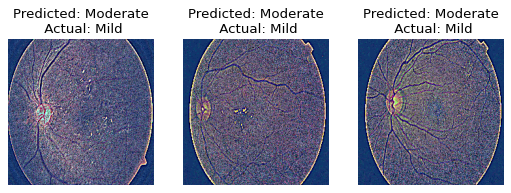

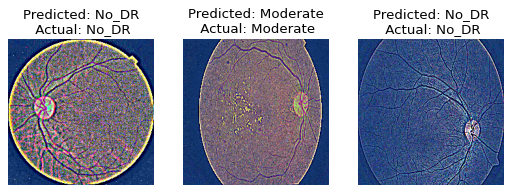

In [ ]:
load_weights()
display_examples(dataset, dataloader, net)

##### Case III: 3 class per client

In [ ]:
trainloaders, valloaders=data_splitter([0.33,0.005,0.005,0.33,0.33],[0.33,0.33,0.005,0.005,0.33],[0.33,0.33,0.33,0.005,0.005],[0.005,0.33,0.33,0.33,0.005],[0.005,0.005,0.33,0.33,0.33])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 837
Client 1 - Test Size: 146
Client 2 - Train Size: 418
Client 2 - Test Size: 146
Client 3 - Train Size: 398
Client 3 - Test Size: 146
Client 4 - Train Size: 607
Client 4 - Test Size: 146
Client 5 - Train Size: 669
Client 5 - Test Size: 149


In [ ]:
net = Net().to(DEVICE)
run_fedAvg()

INFO flwr 2023-04-16 22:34:56,229 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-16 22:34:58,666	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-16 22:35:00,047 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'object_store_memory': 3959054745.0, 'memory': 7918109492.0, 'CPU': 2.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'object_store_memory': 3959054745.0, 'memory': 7918109492.0, 'CPU': 2.0, 'GPU': 1.0}
INFO flwr 2023-04-16 22:35:00,055 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-16 22:35:00,064 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=20689) Adam (
(launch_and_fit pid=20689) Parameter Group 0
(launch_and_fit pid=20689)     amsgrad: False
(launch_and_fit pid=20689)     betas: (0.9, 0.999)
(launch_and_fit pid=20689)     capturable: False
(launch_and_fit pid=20689)     differentiable: False
(launch_and_fit pid=20689)     eps: 1e-08
(launch_and_fit pid=20689)     foreach: None
(launch_and_fit pid=20689)     fused: None
(launch_and_fit pid=20689)     lr: 0.001
(launch_and_fit pid=20689)     maximize: False
(launch_and_fit pid=20689)     weight_decay: 0
(launch_and_fit pid=20689) )


100%|██████████| 105/105 [00:04<00:00, 24.34it/s]
(launch_and_fit pid=20809) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=20809)   warnings.warn(
(launch_and_fit pid=20809) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=20809)   warnings.warn(msg)


(launch_and_fit pid=20809) Adam (
(launch_and_fit pid=20809) Parameter Group 0
(launch_and_fit pid=20809)     amsgrad: False
(launch_and_fit pid=20809)     betas: (0.9, 0.999)
(launch_and_fit pid=20809)     capturable: False
(launch_and_fit pid=20809)     differentiable: False
(launch_and_fit pid=20809)     eps: 1e-08
(launch_and_fit pid=20809)     foreach: None
(launch_and_fit pid=20809)     fused: None
(launch_and_fit pid=20809)     lr: 0.001
(launch_and_fit pid=20809)     maximize: False
(launch_and_fit pid=20809)     weight_decay: 0
(launch_and_fit pid=20809) )


100%|██████████| 84/84 [00:04<00:00, 20.73it/s]
(launch_and_fit pid=20920) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=20920)   warnings.warn(
(launch_and_fit pid=20920) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=20920)   warnings.warn(msg)


(launch_and_fit pid=20920) Adam (
(launch_and_fit pid=20920) Parameter Group 0
(launch_and_fit pid=20920)     amsgrad: False
(launch_and_fit pid=20920)     betas: (0.9, 0.999)
(launch_and_fit pid=20920)     capturable: False
(launch_and_fit pid=20920)     differentiable: False
(launch_and_fit pid=20920)     eps: 1e-08
(launch_and_fit pid=20920)     foreach: None
(launch_and_fit pid=20920)     fused: None
(launch_and_fit pid=20920)     lr: 0.001
(launch_and_fit pid=20920)     maximize: False
(launch_and_fit pid=20920)     weight_decay: 0
(launch_and_fit pid=20920) )


100%|██████████| 76/76 [00:03<00:00, 24.48it/s]
(launch_and_fit pid=21013) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21013)   warnings.warn(
(launch_and_fit pid=21013) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21013)   warnings.warn(msg)


(launch_and_fit pid=21013) Adam (
(launch_and_fit pid=21013) Parameter Group 0
(launch_and_fit pid=21013)     amsgrad: False
(launch_and_fit pid=21013)     betas: (0.9, 0.999)
(launch_and_fit pid=21013)     capturable: False
(launch_and_fit pid=21013)     differentiable: False
(launch_and_fit pid=21013)     eps: 1e-08
(launch_and_fit pid=21013)     foreach: None
(launch_and_fit pid=21013)     fused: None
(launch_and_fit pid=21013)     lr: 0.001
(launch_and_fit pid=21013)     maximize: False
(launch_and_fit pid=21013)     weight_decay: 0
(launch_and_fit pid=21013) )


100%|██████████| 53/53 [00:02<00:00, 18.98it/s]
(launch_and_fit pid=21104) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21104)   warnings.warn(
(launch_and_fit pid=21104) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21104)   warnings.warn(msg)


(launch_and_fit pid=21104) Adam (
(launch_and_fit pid=21104) Parameter Group 0
(launch_and_fit pid=21104)     amsgrad: False
(launch_and_fit pid=21104)     betas: (0.9, 0.999)
(launch_and_fit pid=21104)     capturable: False
(launch_and_fit pid=21104)     differentiable: False
(launch_and_fit pid=21104)     eps: 1e-08
(launch_and_fit pid=21104)     foreach: None
(launch_and_fit pid=21104)     fused: None
(launch_and_fit pid=21104)     lr: 0.001
(launch_and_fit pid=21104)     maximize: False
(launch_and_fit pid=21104)     weight_decay: 0
(launch_and_fit pid=21104) )


100%|██████████| 50/50 [00:02<00:00, 22.54it/s]
DEBUG flwr 2023-04-16 22:35:46,276 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-16 22:35:49,345 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-16 22:35:49,380 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=21208) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=21208)   warnings.warn(
(launch_and_evaluate pid=21208) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

(launch_and_fit pid=21545) Adam (
(launch_and_fit pid=21545) Parameter Group 0
(launch_and_fit pid=21545)     amsgrad: False
(launch_and_fit pid=21545)     betas: (0.9, 0.999)
(launch_and_fit pid=21545)     capturable: False
(launch_and_fit pid=21545)     differentiable: False
(launch_and_fit pid=21545)     eps: 1e-08
(launch_and_fit pid=21545)     foreach: None
(launch_and_fit pid=21545)     fused: None
(launch_and_fit pid=21545)     lr: 0.001
(launch_and_fit pid=21545)     maximize: False
(launch_and_fit pid=21545)     weight_decay: 0
(launch_and_fit pid=21545) )


100%|██████████| 53/53 [00:02<00:00, 22.55it/s]
(launch_and_fit pid=21637) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21637)   warnings.warn(
(launch_and_fit pid=21637) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21637)   warnings.warn(msg)
  0%|          | 0/84 [00:00<?, ?it/s]


(launch_and_fit pid=21637) Adam (
(launch_and_fit pid=21637) Parameter Group 0
(launch_and_fit pid=21637)     amsgrad: False
(launch_and_fit pid=21637)     betas: (0.9, 0.999)
(launch_and_fit pid=21637)     capturable: False
(launch_and_fit pid=21637)     differentiable: False
(launch_and_fit pid=21637)     eps: 1e-08
(launch_and_fit pid=21637)     foreach: None
(launch_and_fit pid=21637)     fused: None
(launch_and_fit pid=21637)     lr: 0.001
(launch_and_fit pid=21637)     maximize: False
(launch_and_fit pid=21637)     weight_decay: 0
(launch_and_fit pid=21637) )


100%|██████████| 84/84 [00:03<00:00, 24.68it/s]
(launch_and_fit pid=21743) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21743)   warnings.warn(
(launch_and_fit pid=21743) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21743)   warnings.warn(msg)
  0%|          | 0/76 [00:00<?, ?it/s]


(launch_and_fit pid=21743) Adam (
(launch_and_fit pid=21743) Parameter Group 0
(launch_and_fit pid=21743)     amsgrad: False
(launch_and_fit pid=21743)     betas: (0.9, 0.999)
(launch_and_fit pid=21743)     capturable: False
(launch_and_fit pid=21743)     differentiable: False
(launch_and_fit pid=21743)     eps: 1e-08
(launch_and_fit pid=21743)     foreach: None
(launch_and_fit pid=21743)     fused: None
(launch_and_fit pid=21743)     lr: 0.001
(launch_and_fit pid=21743)     maximize: False
(launch_and_fit pid=21743)     weight_decay: 0
(launch_and_fit pid=21743) )


100%|██████████| 76/76 [00:03<00:00, 22.56it/s]
(launch_and_fit pid=21840) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21840)   warnings.warn(
(launch_and_fit pid=21840) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21840)   warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]


(launch_and_fit pid=21840) Adam (
(launch_and_fit pid=21840) Parameter Group 0
(launch_and_fit pid=21840)     amsgrad: False
(launch_and_fit pid=21840)     betas: (0.9, 0.999)
(launch_and_fit pid=21840)     capturable: False
(launch_and_fit pid=21840)     differentiable: False
(launch_and_fit pid=21840)     eps: 1e-08
(launch_and_fit pid=21840)     foreach: None
(launch_and_fit pid=21840)     fused: None
(launch_and_fit pid=21840)     lr: 0.001
(launch_and_fit pid=21840)     maximize: False
(launch_and_fit pid=21840)     weight_decay: 0
(launch_and_fit pid=21840) )


100%|██████████| 50/50 [00:02<00:00, 22.15it/s]
(launch_and_fit pid=21840) 
(launch_and_fit pid=21934) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21934)   warnings.warn(
(launch_and_fit pid=21934) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21934)   warnings.warn(msg)


(launch_and_fit pid=21934) Adam (
(launch_and_fit pid=21934) Parameter Group 0
(launch_and_fit pid=21934)     amsgrad: False
(launch_and_fit pid=21934)     betas: (0.9, 0.999)
(launch_and_fit pid=21934)     capturable: False
(launch_and_fit pid=21934)     differentiable: False
(launch_and_fit pid=21934)     eps: 1e-08
(launch_and_fit pid=21934)     foreach: None
(launch_and_fit pid=21934)     fused: None
(launch_and_fit pid=21934)     lr: 0.001
(launch_and_fit pid=21934)     maximize: False
(launch_and_fit pid=21934)     weight_decay: 0
(launch_and_fit pid=21934) )


100%|██████████| 105/105 [00:04<00:00, 23.32it/s]
DEBUG flwr 2023-04-16 22:36:58,253 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-16 22:37:02,590 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(raylet) Spilled 3269 MiB, 31 objects, write throughput 225 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(launch_and_evaluate pid=22072) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=22072)   warnings.warn(
(launch_and_evaluate pid=22072) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be 

(launch_and_fit pid=22604) Adam (
(launch_and_fit pid=22604) Parameter Group 0
(launch_and_fit pid=22604)     amsgrad: False
(launch_and_fit pid=22604)     betas: (0.9, 0.999)
(launch_and_fit pid=22604)     capturable: False
(launch_and_fit pid=22604)     differentiable: False
(launch_and_fit pid=22604)     eps: 1e-08
(launch_and_fit pid=22604)     foreach: None
(launch_and_fit pid=22604)     fused: None
(launch_and_fit pid=22604)     lr: 0.001
(launch_and_fit pid=22604)     maximize: False
(launch_and_fit pid=22604)     weight_decay: 0
(launch_and_fit pid=22604) )


100%|██████████| 105/105 [00:06<00:00, 15.86it/s]
(launch_and_fit pid=22759) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=22759)   warnings.warn(
(launch_and_fit pid=22759) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=22759)   warnings.warn(msg)


(launch_and_fit pid=22759) Adam (
(launch_and_fit pid=22759) Parameter Group 0
(launch_and_fit pid=22759)     amsgrad: False
(launch_and_fit pid=22759)     betas: (0.9, 0.999)
(launch_and_fit pid=22759)     capturable: False
(launch_and_fit pid=22759)     differentiable: False
(launch_and_fit pid=22759)     eps: 1e-08
(launch_and_fit pid=22759)     foreach: None
(launch_and_fit pid=22759)     fused: None
(launch_and_fit pid=22759)     lr: 0.001
(launch_and_fit pid=22759)     maximize: False
(launch_and_fit pid=22759)     weight_decay: 0
(launch_and_fit pid=22759) )


100%|██████████| 84/84 [00:04<00:00, 16.90it/s]
(launch_and_fit pid=22882) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=22882)   warnings.warn(
(launch_and_fit pid=22882) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=22882)   warnings.warn(msg)


(launch_and_fit pid=22882) Adam (
(launch_and_fit pid=22882) Parameter Group 0
(launch_and_fit pid=22882)     amsgrad: False
(launch_and_fit pid=22882)     betas: (0.9, 0.999)
(launch_and_fit pid=22882)     capturable: False
(launch_and_fit pid=22882)     differentiable: False
(launch_and_fit pid=22882)     eps: 1e-08
(launch_and_fit pid=22882)     foreach: None
(launch_and_fit pid=22882)     fused: None
(launch_and_fit pid=22882)     lr: 0.001
(launch_and_fit pid=22882)     maximize: False
(launch_and_fit pid=22882)     weight_decay: 0
(launch_and_fit pid=22882) )


100%|██████████| 76/76 [00:03<00:00, 19.33it/s]
(launch_and_fit pid=22991) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=22991)   warnings.warn(
(launch_and_fit pid=22991) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=22991)   warnings.warn(msg)
  0%|          | 0/53 [00:00<?, ?it/s]


(launch_and_fit pid=22991) Adam (
(launch_and_fit pid=22991) Parameter Group 0
(launch_and_fit pid=22991)     amsgrad: False
(launch_and_fit pid=22991)     betas: (0.9, 0.999)
(launch_and_fit pid=22991)     capturable: False
(launch_and_fit pid=22991)     differentiable: False
(launch_and_fit pid=22991)     eps: 1e-08
(launch_and_fit pid=22991)     foreach: None
(launch_and_fit pid=22991)     fused: None
(launch_and_fit pid=22991)     lr: 0.001
(launch_and_fit pid=22991)     maximize: False
(launch_and_fit pid=22991)     weight_decay: 0
(launch_and_fit pid=22991) )


100%|██████████| 53/53 [00:03<00:00, 16.62it/s]
(launch_and_fit pid=23085) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=23085)   warnings.warn(
(launch_and_fit pid=23085) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=23085)   warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]


(launch_and_fit pid=23085) Adam (
(launch_and_fit pid=23085) Parameter Group 0
(launch_and_fit pid=23085)     amsgrad: False
(launch_and_fit pid=23085)     betas: (0.9, 0.999)
(launch_and_fit pid=23085)     capturable: False
(launch_and_fit pid=23085)     differentiable: False
(launch_and_fit pid=23085)     eps: 1e-08
(launch_and_fit pid=23085)     foreach: None
(launch_and_fit pid=23085)     fused: None
(launch_and_fit pid=23085)     lr: 0.001
(launch_and_fit pid=23085)     maximize: False
(launch_and_fit pid=23085)     weight_decay: 0
(launch_and_fit pid=23085) )


100%|██████████| 50/50 [00:02<00:00, 18.22it/s]
DEBUG flwr 2023-04-16 22:38:37,407 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-16 22:38:41,437 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=23208) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=23208)   warnings.warn(
(launch_and_evaluate pid=23208) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

(scheduler +1h3m59s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +1h3m59s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_fit pid=23592) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=23592)   warnings.warn(
(launch_and_fit pid=23592) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=23592)   warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]


(launch_and_fit pid=23592) Adam (
(launch_and_fit pid=23592) Parameter Group 0
(launch_and_fit pid=23592)     amsgrad: False
(launch_and_fit pid=23592)     betas: (0.9, 0.999)
(launch_and_fit pid=23592)     capturable: False
(launch_and_fit pid=23592)     differentiable: False
(launch_and_fit pid=23592)     eps: 1e-08
(launch_and_fit pid=23592)     foreach: None
(launch_and_fit pid=23592)     fused: None
(launch_and_fit pid=23592)     lr: 0.001
(launch_and_fit pid=23592)     maximize: False
(launch_and_fit pid=23592)     weight_decay: 0
(launch_and_fit pid=23592) )


100%|██████████| 50/50 [00:03<00:00, 12.58it/s]
(launch_and_fit pid=23709) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=23709)   warnings.warn(
(launch_and_fit pid=23709) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=23709)   warnings.warn(msg)


(launch_and_fit pid=23709) Adam (
(launch_and_fit pid=23709) Parameter Group 0
(launch_and_fit pid=23709)     amsgrad: False
(launch_and_fit pid=23709)     betas: (0.9, 0.999)
(launch_and_fit pid=23709)     capturable: False
(launch_and_fit pid=23709)     differentiable: False
(launch_and_fit pid=23709)     eps: 1e-08
(launch_and_fit pid=23709)     foreach: None
(launch_and_fit pid=23709)     fused: None
(launch_and_fit pid=23709)     lr: 0.001
(launch_and_fit pid=23709)     maximize: False
(launch_and_fit pid=23709)     weight_decay: 0
(launch_and_fit pid=23709) )


100%|██████████| 76/76 [00:04<00:00, 17.45it/s]
(launch_and_fit pid=23815) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=23815)   warnings.warn(
(launch_and_fit pid=23815) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=23815)   warnings.warn(msg)


(launch_and_fit pid=23815) Adam (
(launch_and_fit pid=23815) Parameter Group 0
(launch_and_fit pid=23815)     amsgrad: False
(launch_and_fit pid=23815)     betas: (0.9, 0.999)
(launch_and_fit pid=23815)     capturable: False
(launch_and_fit pid=23815)     differentiable: False
(launch_and_fit pid=23815)     eps: 1e-08
(launch_and_fit pid=23815)     foreach: None
(launch_and_fit pid=23815)     fused: None
(launch_and_fit pid=23815)     lr: 0.001
(launch_and_fit pid=23815)     maximize: False
(launch_and_fit pid=23815)     weight_decay: 0
(launch_and_fit pid=23815) )


100%|██████████| 84/84 [00:04<00:00, 18.00it/s]
(launch_and_fit pid=23930) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=23930)   warnings.warn(
(launch_and_fit pid=23930) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=23930)   warnings.warn(msg)
  0%|          | 0/105 [00:00<?, ?it/s]


(launch_and_fit pid=23930) Adam (
(launch_and_fit pid=23930) Parameter Group 0
(launch_and_fit pid=23930)     amsgrad: False
(launch_and_fit pid=23930)     betas: (0.9, 0.999)
(launch_and_fit pid=23930)     capturable: False
(launch_and_fit pid=23930)     differentiable: False
(launch_and_fit pid=23930)     eps: 1e-08
(launch_and_fit pid=23930)     foreach: None
(launch_and_fit pid=23930)     fused: None
(launch_and_fit pid=23930)     lr: 0.001
(launch_and_fit pid=23930)     maximize: False
(launch_and_fit pid=23930)     weight_decay: 0
(launch_and_fit pid=23930) )


 29%|██▊       | 30/105 [00:01<00:03, 20.38it/s]


(scheduler +1h4m34s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 105/105 [00:05<00:00, 18.39it/s]
(launch_and_fit pid=24060) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=24060)   warnings.warn(
(launch_and_fit pid=24060) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=24060)   warnings.warn(msg)
  0%|          | 0/53 [00:00<?, ?it/s]


(launch_and_fit pid=24060) Adam (
(launch_and_fit pid=24060) Parameter Group 0
(launch_and_fit pid=24060)     amsgrad: False
(launch_and_fit pid=24060)     betas: (0.9, 0.999)
(launch_and_fit pid=24060)     capturable: False
(launch_and_fit pid=24060)     differentiable: False
(launch_and_fit pid=24060)     eps: 1e-08
(launch_and_fit pid=24060)     foreach: None
(launch_and_fit pid=24060)     fused: None
(launch_and_fit pid=24060)     lr: 0.001
(launch_and_fit pid=24060)     maximize: False
(launch_and_fit pid=24060)     weight_decay: 0
(launch_and_fit pid=24060) )


100%|██████████| 53/53 [00:02<00:00, 18.33it/s]
DEBUG flwr 2023-04-16 22:40:07,875 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-16 22:40:12,042 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=24173) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=24173)   warnings.warn(
(launch_and_evaluate pid=24173) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

(launch_and_fit pid=24551) Adam (
(launch_and_fit pid=24551) Parameter Group 0
(launch_and_fit pid=24551)     amsgrad: False
(launch_and_fit pid=24551)     betas: (0.9, 0.999)
(launch_and_fit pid=24551)     capturable: False
(launch_and_fit pid=24551)     differentiable: False
(launch_and_fit pid=24551)     eps: 1e-08
(launch_and_fit pid=24551)     foreach: None
(launch_and_fit pid=24551)     fused: None
(launch_and_fit pid=24551)     lr: 0.001
(launch_and_fit pid=24551)     maximize: False
(launch_and_fit pid=24551)     weight_decay: 0
(launch_and_fit pid=24551) )


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]
(launch_and_fit pid=24662) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=24662)   warnings.warn(
(launch_and_fit pid=24662) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=24662)   warnings.warn(msg)


(launch_and_fit pid=24662) Adam (
(launch_and_fit pid=24662) Parameter Group 0
(launch_and_fit pid=24662)     amsgrad: False
(launch_and_fit pid=24662)     betas: (0.9, 0.999)
(launch_and_fit pid=24662)     capturable: False
(launch_and_fit pid=24662)     differentiable: False
(launch_and_fit pid=24662)     eps: 1e-08
(launch_and_fit pid=24662)     foreach: None
(launch_and_fit pid=24662)     fused: None
(launch_and_fit pid=24662)     lr: 0.001
(launch_and_fit pid=24662)     maximize: False
(launch_and_fit pid=24662)     weight_decay: 0
(launch_and_fit pid=24662) )


100%|██████████| 76/76 [00:04<00:00, 18.03it/s]
(raylet) Spilled 8283 MiB, 78 objects, write throughput 223 MiB/s.
(launch_and_fit pid=24777) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=24777)   warnings.warn(
(launch_and_fit pid=24777) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=24777)   warnings.warn(msg)
  0%|          | 0/53 [00:00<?, ?it/s]


(launch_and_fit pid=24777) Adam (
(launch_and_fit pid=24777) Parameter Group 0
(launch_and_fit pid=24777)     amsgrad: False
(launch_and_fit pid=24777)     betas: (0.9, 0.999)
(launch_and_fit pid=24777)     capturable: False
(launch_and_fit pid=24777)     differentiable: False
(launch_and_fit pid=24777)     eps: 1e-08
(launch_and_fit pid=24777)     foreach: None
(launch_and_fit pid=24777)     fused: None
(launch_and_fit pid=24777)     lr: 0.001
(launch_and_fit pid=24777)     maximize: False
(launch_and_fit pid=24777)     weight_decay: 0
(launch_and_fit pid=24777) )


100%|██████████| 53/53 [00:02<00:00, 17.82it/s]
(launch_and_fit pid=24885) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=24885)   warnings.warn(
(launch_and_fit pid=24885) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=24885)   warnings.warn(msg)
  0%|          | 0/105 [00:00<?, ?it/s]


(launch_and_fit pid=24885) Adam (
(launch_and_fit pid=24885) Parameter Group 0
(launch_and_fit pid=24885)     amsgrad: False
(launch_and_fit pid=24885)     betas: (0.9, 0.999)
(launch_and_fit pid=24885)     capturable: False
(launch_and_fit pid=24885)     differentiable: False
(launch_and_fit pid=24885)     eps: 1e-08
(launch_and_fit pid=24885)     foreach: None
(launch_and_fit pid=24885)     fused: None
(launch_and_fit pid=24885)     lr: 0.001
(launch_and_fit pid=24885)     maximize: False
(launch_and_fit pid=24885)     weight_decay: 0
(launch_and_fit pid=24885) )


100%|██████████| 105/105 [00:06<00:00, 15.94it/s]
(launch_and_fit pid=25025) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=25025)   warnings.warn(
(launch_and_fit pid=25025) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=25025)   warnings.warn(msg)
  0%|          | 0/84 [00:00<?, ?it/s]


(launch_and_fit pid=25025) Adam (
(launch_and_fit pid=25025) Parameter Group 0
(launch_and_fit pid=25025)     amsgrad: False
(launch_and_fit pid=25025)     betas: (0.9, 0.999)
(launch_and_fit pid=25025)     capturable: False
(launch_and_fit pid=25025)     differentiable: False
(launch_and_fit pid=25025)     eps: 1e-08
(launch_and_fit pid=25025)     foreach: None
(launch_and_fit pid=25025)     fused: None
(launch_and_fit pid=25025)     lr: 0.001
(launch_and_fit pid=25025)     maximize: False
(launch_and_fit pid=25025)     weight_decay: 0
(launch_and_fit pid=25025) )


100%|██████████| 84/84 [00:04<00:00, 20.13it/s]
DEBUG flwr 2023-04-16 22:41:38,216 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-16 22:41:43,155 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=25162) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=25162)   warnings.warn(
(launch_and_evaluate pid=25162) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

Loading pre-trained model from:  ./model_round_5.pth


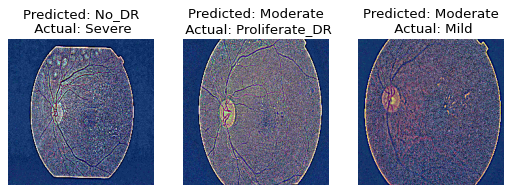

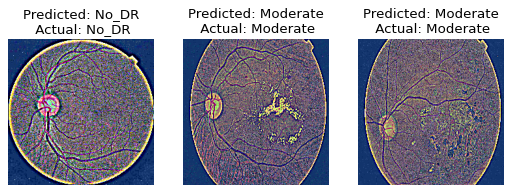

In [ ]:
load_weights()
display_examples(dataset, dataloader, net)

##### Case IV: 4 class per client

In [ ]:
trainloaders, valloaders=data_splitter([0.2499,0.0004,0.2499,0.2499,0.2499],[0.2499,0.2499,0.0004,0.2499,0.2499],[0.2499,0.2499,0.2499,0.0004,0.2499],[0.2499,0.2499,0.2499,0.2499,0.0004],[0.0004,0.2499,0.2499,0.2499,0.2499])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 670
Client 1 - Test Size: 146
Client 2 - Train Size: 368
Client 2 - Test Size: 146
Client 3 - Train Size: 655
Client 3 - Test Size: 146
Client 4 - Train Size: 529
Client 4 - Test Size: 146
Client 5 - Train Size: 707
Client 5 - Test Size: 149


In [ ]:
net = Net().to(DEVICE)
run_fedAvg()

INFO flwr 2023-04-20 20:38:33,011 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-20 20:38:35,532	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-20 20:38:37,015 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 8000163840.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 4000081920.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8000163840.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 4000081920.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-04-20 20:38:37,027 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-20 20:38:37,033 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=18722) Adam (
(launch_and_fit pid=18722) Parameter Group 0
(launch_and_fit pid=18722)     amsgrad: False
(launch_and_fit pid=18722)     betas: (0.9, 0.999)
(launch_and_fit pid=18722)     capturable: False
(launch_and_fit pid=18722)     differentiable: False
(launch_and_fit pid=18722)     eps: 1e-08
(launch_and_fit pid=18722)     foreach: None
(launch_and_fit pid=18722)     fused: None
(launch_and_fit pid=18722)     lr: 0.001
(launch_and_fit pid=18722)     maximize: False
(launch_and_fit pid=18722)     weight_decay: 0
(launch_and_fit pid=18722) )


100%|██████████| 84/84 [00:06<00:00, 13.23it/s]
(launch_and_fit pid=18861) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=18861)   warnings.warn(
(launch_and_fit pid=18861) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=18861)   warnings.warn(msg)
  0%|          | 0/82 [00:00<?, ?it/s]


(launch_and_fit pid=18861) Adam (
(launch_and_fit pid=18861) Parameter Group 0
(launch_and_fit pid=18861)     amsgrad: False
(launch_and_fit pid=18861)     betas: (0.9, 0.999)
(launch_and_fit pid=18861)     capturable: False
(launch_and_fit pid=18861)     differentiable: False
(launch_and_fit pid=18861)     eps: 1e-08
(launch_and_fit pid=18861)     foreach: None
(launch_and_fit pid=18861)     fused: None
(launch_and_fit pid=18861)     lr: 0.001
(launch_and_fit pid=18861)     maximize: False
(launch_and_fit pid=18861)     weight_decay: 0
(launch_and_fit pid=18861) )
(scheduler +1m45s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +1m45s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 82/82 [00:05<00:00, 15.58it/s]
(launch_and_fit pid=18986) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=18986)   warnings.warn(
(launch_and_fit pid=18986) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=18986)   warnings.warn(msg)
  0%|          | 0/89 [00:00<?, ?it/s]


(launch_and_fit pid=18986) Adam (
(launch_and_fit pid=18986) Parameter Group 0
(launch_and_fit pid=18986)     amsgrad: False
(launch_and_fit pid=18986)     betas: (0.9, 0.999)
(launch_and_fit pid=18986)     capturable: False
(launch_and_fit pid=18986)     differentiable: False
(launch_and_fit pid=18986)     eps: 1e-08
(launch_and_fit pid=18986)     foreach: None
(launch_and_fit pid=18986)     fused: None
(launch_and_fit pid=18986)     lr: 0.001
(launch_and_fit pid=18986)     maximize: False
(launch_and_fit pid=18986)     weight_decay: 0
(launch_and_fit pid=18986) )


100%|██████████| 89/89 [00:04<00:00, 19.64it/s]
(launch_and_fit pid=19095) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19095)   warnings.warn(
(launch_and_fit pid=19095) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19095)   warnings.warn(msg)
  0%|          | 0/67 [00:00<?, ?it/s]


(launch_and_fit pid=19095) Adam (
(launch_and_fit pid=19095) Parameter Group 0
(launch_and_fit pid=19095)     amsgrad: False
(launch_and_fit pid=19095)     betas: (0.9, 0.999)
(launch_and_fit pid=19095)     capturable: False
(launch_and_fit pid=19095)     differentiable: False
(launch_and_fit pid=19095)     eps: 1e-08
(launch_and_fit pid=19095)     foreach: None
(launch_and_fit pid=19095)     fused: None
(launch_and_fit pid=19095)     lr: 0.001
(launch_and_fit pid=19095)     maximize: False
(launch_and_fit pid=19095)     weight_decay: 0
(launch_and_fit pid=19095) )


100%|██████████| 67/67 [00:03<00:00, 20.20it/s]
(launch_and_fit pid=19199) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19199)   warnings.warn(
(launch_and_fit pid=19199) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19199)   warnings.warn(msg)


(launch_and_fit pid=19199) Adam (
(launch_and_fit pid=19199) Parameter Group 0
(launch_and_fit pid=19199)     amsgrad: False
(launch_and_fit pid=19199)     betas: (0.9, 0.999)
(launch_and_fit pid=19199)     capturable: False
(launch_and_fit pid=19199)     differentiable: False
(launch_and_fit pid=19199)     eps: 1e-08
(launch_and_fit pid=19199)     foreach: None
(launch_and_fit pid=19199)     fused: None
(launch_and_fit pid=19199)     lr: 0.001
(launch_and_fit pid=19199)     maximize: False
(launch_and_fit pid=19199)     weight_decay: 0
(launch_and_fit pid=19199) )


100%|██████████| 46/46 [00:02<00:00, 18.81it/s]
DEBUG flwr 2023-04-20 20:39:31,326 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-20 20:39:33,598 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-04-20 20:39:34,775 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=19312) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=19312)   warnings.warn(
(launch_and_evaluate pid=19312) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=19312)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 18.66it/s]
(launch_and_evaluate pid=1937

(launch_and_fit pid=19652) Adam (
(launch_and_fit pid=19652) Parameter Group 0
(launch_and_fit pid=19652)     amsgrad: False
(launch_and_fit pid=19652)     betas: (0.9, 0.999)
(launch_and_fit pid=19652)     capturable: False
(launch_and_fit pid=19652)     differentiable: False
(launch_and_fit pid=19652)     eps: 1e-08
(launch_and_fit pid=19652)     foreach: None
(launch_and_fit pid=19652)     fused: None
(launch_and_fit pid=19652)     lr: 0.001
(launch_and_fit pid=19652)     maximize: False
(launch_and_fit pid=19652)     weight_decay: 0
(launch_and_fit pid=19652) )


100%|██████████| 89/89 [00:04<00:00, 19.80it/s]
(launch_and_fit pid=19768) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19768)   warnings.warn(
(launch_and_fit pid=19768) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19768)   warnings.warn(msg)


(launch_and_fit pid=19768) Adam (
(launch_and_fit pid=19768) Parameter Group 0
(launch_and_fit pid=19768)     amsgrad: False
(launch_and_fit pid=19768)     betas: (0.9, 0.999)
(launch_and_fit pid=19768)     capturable: False
(launch_and_fit pid=19768)     differentiable: False
(launch_and_fit pid=19768)     eps: 1e-08
(launch_and_fit pid=19768)     foreach: None
(launch_and_fit pid=19768)     fused: None
(launch_and_fit pid=19768)     lr: 0.001
(launch_and_fit pid=19768)     maximize: False
(launch_and_fit pid=19768)     weight_decay: 0
(launch_and_fit pid=19768) )


100%|██████████| 46/46 [00:02<00:00, 20.91it/s]
(launch_and_fit pid=19851) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19851)   warnings.warn(
(launch_and_fit pid=19851) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19851)   warnings.warn(msg)
  0%|          | 0/82 [00:00<?, ?it/s]


(launch_and_fit pid=19851) Adam (
(launch_and_fit pid=19851) Parameter Group 0
(launch_and_fit pid=19851)     amsgrad: False
(launch_and_fit pid=19851)     betas: (0.9, 0.999)
(launch_and_fit pid=19851)     capturable: False
(launch_and_fit pid=19851)     differentiable: False
(launch_and_fit pid=19851)     eps: 1e-08
(launch_and_fit pid=19851)     foreach: None
(launch_and_fit pid=19851)     fused: None
(launch_and_fit pid=19851)     lr: 0.001
(launch_and_fit pid=19851)     maximize: False
(launch_and_fit pid=19851)     weight_decay: 0
(launch_and_fit pid=19851) )


100%|██████████| 82/82 [00:04<00:00, 19.29it/s]
(launch_and_fit pid=19962) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19962)   warnings.warn(
(launch_and_fit pid=19962) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19962)   warnings.warn(msg)


(launch_and_fit pid=19962) Adam (
(launch_and_fit pid=19962) Parameter Group 0
(launch_and_fit pid=19962)     amsgrad: False
(launch_and_fit pid=19962)     betas: (0.9, 0.999)
(launch_and_fit pid=19962)     capturable: False
(launch_and_fit pid=19962)     differentiable: False
(launch_and_fit pid=19962)     eps: 1e-08
(launch_and_fit pid=19962)     foreach: None
(launch_and_fit pid=19962)     fused: None
(launch_and_fit pid=19962)     lr: 0.001
(launch_and_fit pid=19962)     maximize: False
(launch_and_fit pid=19962)     weight_decay: 0
(launch_and_fit pid=19962) )


100%|██████████| 84/84 [00:03<00:00, 21.93it/s]
(launch_and_fit pid=20064) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=20064)   warnings.warn(
(launch_and_fit pid=20064) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=20064)   warnings.warn(msg)


(launch_and_fit pid=20064) Adam (
(launch_and_fit pid=20064) Parameter Group 0
(launch_and_fit pid=20064)     amsgrad: False
(launch_and_fit pid=20064)     betas: (0.9, 0.999)
(launch_and_fit pid=20064)     capturable: False
(launch_and_fit pid=20064)     differentiable: False
(launch_and_fit pid=20064)     eps: 1e-08
(launch_and_fit pid=20064)     foreach: None
(launch_and_fit pid=20064)     fused: None
(launch_and_fit pid=20064)     lr: 0.001
(launch_and_fit pid=20064)     maximize: False
(launch_and_fit pid=20064)     weight_decay: 0
(launch_and_fit pid=20064) )


100%|██████████| 67/67 [00:03<00:00, 20.00it/s]
DEBUG flwr 2023-04-20 20:40:46,831 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-04-20 20:40:51,170 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=20198) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=20198)   warnings.warn(
(launch_and_evaluate pid=20198) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=20198)   warnings.warn(msg)
(raylet) Spilled 3052 MiB, 30 objects, write throughput 212 MiB/s. Set RAY_ve

(launch_and_fit pid=20727) Adam (
(launch_and_fit pid=20727) Parameter Group 0
(launch_and_fit pid=20727)     amsgrad: False
(launch_and_fit pid=20727)     betas: (0.9, 0.999)
(launch_and_fit pid=20727)     capturable: False
(launch_and_fit pid=20727)     differentiable: False
(launch_and_fit pid=20727)     eps: 1e-08
(launch_and_fit pid=20727)     foreach: None
(launch_and_fit pid=20727)     fused: None
(launch_and_fit pid=20727)     lr: 0.001
(launch_and_fit pid=20727)     maximize: False
(launch_and_fit pid=20727)     weight_decay: 0
(launch_and_fit pid=20727) )


100%|██████████| 82/82 [00:05<00:00, 16.28it/s]
(raylet) Spilled 4142 MiB, 40 objects, write throughput 210 MiB/s.
(launch_and_fit pid=20872) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=20872)   warnings.warn(
(launch_and_fit pid=20872) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=20872)   warnings.warn(msg)
  0%|          | 0/89 [00:00<?, ?it/s]


(launch_and_fit pid=20872) Adam (
(launch_and_fit pid=20872) Parameter Group 0
(launch_and_fit pid=20872)     amsgrad: False
(launch_and_fit pid=20872)     betas: (0.9, 0.999)
(launch_and_fit pid=20872)     capturable: False
(launch_and_fit pid=20872)     differentiable: False
(launch_and_fit pid=20872)     eps: 1e-08
(launch_and_fit pid=20872)     foreach: None
(launch_and_fit pid=20872)     fused: None
(launch_and_fit pid=20872)     lr: 0.001
(launch_and_fit pid=20872)     maximize: False
(launch_and_fit pid=20872)     weight_decay: 0
(launch_and_fit pid=20872) )


100%|██████████| 89/89 [00:06<00:00, 14.01it/s]
(launch_and_fit pid=21009) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21009)   warnings.warn(
(launch_and_fit pid=21009) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21009)   warnings.warn(msg)
  0%|          | 0/84 [00:00<?, ?it/s]


(launch_and_fit pid=21009) Adam (
(launch_and_fit pid=21009) Parameter Group 0
(launch_and_fit pid=21009)     amsgrad: False
(launch_and_fit pid=21009)     betas: (0.9, 0.999)
(launch_and_fit pid=21009)     capturable: False
(launch_and_fit pid=21009)     differentiable: False
(launch_and_fit pid=21009)     eps: 1e-08
(launch_and_fit pid=21009)     foreach: None
(launch_and_fit pid=21009)     fused: None
(launch_and_fit pid=21009)     lr: 0.001
(launch_and_fit pid=21009)     maximize: False
(launch_and_fit pid=21009)     weight_decay: 0
(launch_and_fit pid=21009) )


100%|██████████| 84/84 [00:04<00:00, 17.63it/s]
(launch_and_fit pid=21131) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21131)   warnings.warn(
(launch_and_fit pid=21131) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21131)   warnings.warn(msg)


(launch_and_fit pid=21131) Adam (
(launch_and_fit pid=21131) Parameter Group 0
(launch_and_fit pid=21131)     amsgrad: False
(launch_and_fit pid=21131)     betas: (0.9, 0.999)
(launch_and_fit pid=21131)     capturable: False
(launch_and_fit pid=21131)     differentiable: False
(launch_and_fit pid=21131)     eps: 1e-08
(launch_and_fit pid=21131)     foreach: None
(launch_and_fit pid=21131)     fused: None
(launch_and_fit pid=21131)     lr: 0.001
(launch_and_fit pid=21131)     maximize: False
(launch_and_fit pid=21131)     weight_decay: 0
(launch_and_fit pid=21131) )


100%|██████████| 67/67 [00:03<00:00, 17.32it/s]
(launch_and_fit pid=21239) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21239)   warnings.warn(
(launch_and_fit pid=21239) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21239)   warnings.warn(msg)
  0%|          | 0/46 [00:00<?, ?it/s]


(launch_and_fit pid=21239) Adam (
(launch_and_fit pid=21239) Parameter Group 0
(launch_and_fit pid=21239)     amsgrad: False
(launch_and_fit pid=21239)     betas: (0.9, 0.999)
(launch_and_fit pid=21239)     capturable: False
(launch_and_fit pid=21239)     differentiable: False
(launch_and_fit pid=21239)     eps: 1e-08
(launch_and_fit pid=21239)     foreach: None
(launch_and_fit pid=21239)     fused: None
(launch_and_fit pid=21239)     lr: 0.001
(launch_and_fit pid=21239)     maximize: False
(launch_and_fit pid=21239)     weight_decay: 0
(launch_and_fit pid=21239) )


100%|██████████| 46/46 [00:02<00:00, 18.22it/s]
DEBUG flwr 2023-04-20 20:42:26,794 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-04-20 20:42:34,327 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=21372) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=21372)   warnings.warn(
(launch_and_evaluate pid=21372) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=21372)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 14.61it/s]
(launch_and_evaluate pid=2145

(launch_and_fit pid=21749) Adam (
(launch_and_fit pid=21749) Parameter Group 0
(launch_and_fit pid=21749)     amsgrad: False
(launch_and_fit pid=21749)     betas: (0.9, 0.999)
(launch_and_fit pid=21749)     capturable: False
(launch_and_fit pid=21749)     differentiable: False
(launch_and_fit pid=21749)     eps: 1e-08
(launch_and_fit pid=21749)     foreach: None
(launch_and_fit pid=21749)     fused: None
(launch_and_fit pid=21749)     lr: 0.001
(launch_and_fit pid=21749)     maximize: False
(launch_and_fit pid=21749)     weight_decay: 0
(launch_and_fit pid=21749) )


100%|██████████| 84/84 [00:05<00:00, 15.67it/s]
(launch_and_fit pid=21891) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21891)   warnings.warn(
(launch_and_fit pid=21891) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21891)   warnings.warn(msg)


(launch_and_fit pid=21891) Adam (
(launch_and_fit pid=21891) Parameter Group 0
(launch_and_fit pid=21891)     amsgrad: False
(launch_and_fit pid=21891)     betas: (0.9, 0.999)
(launch_and_fit pid=21891)     capturable: False
(launch_and_fit pid=21891)     differentiable: False
(launch_and_fit pid=21891)     eps: 1e-08
(launch_and_fit pid=21891)     foreach: None
(launch_and_fit pid=21891)     fused: None
(launch_and_fit pid=21891)     lr: 0.001
(launch_and_fit pid=21891)     maximize: False
(launch_and_fit pid=21891)     weight_decay: 0
(launch_and_fit pid=21891) )


100%|██████████| 46/46 [00:02<00:00, 16.36it/s]
(launch_and_fit pid=21997) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=21997)   warnings.warn(
(launch_and_fit pid=21997) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=21997)   warnings.warn(msg)
  0%|          | 0/67 [00:00<?, ?it/s]


(launch_and_fit pid=21997) Adam (
(launch_and_fit pid=21997) Parameter Group 0
(launch_and_fit pid=21997)     amsgrad: False
(launch_and_fit pid=21997)     betas: (0.9, 0.999)
(launch_and_fit pid=21997)     capturable: False
(launch_and_fit pid=21997)     differentiable: False
(launch_and_fit pid=21997)     eps: 1e-08
(launch_and_fit pid=21997)     foreach: None
(launch_and_fit pid=21997)     fused: None
(launch_and_fit pid=21997)     lr: 0.001
(launch_and_fit pid=21997)     maximize: False
(launch_and_fit pid=21997)     weight_decay: 0
(launch_and_fit pid=21997) )


100%|██████████| 67/67 [00:04<00:00, 15.88it/s]
(launch_and_fit pid=22108) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=22108)   warnings.warn(
(launch_and_fit pid=22108) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=22108)   warnings.warn(msg)


(launch_and_fit pid=22108) Adam (
(launch_and_fit pid=22108) Parameter Group 0
(launch_and_fit pid=22108)     amsgrad: False
(launch_and_fit pid=22108)     betas: (0.9, 0.999)
(launch_and_fit pid=22108)     capturable: False
(launch_and_fit pid=22108)     differentiable: False
(launch_and_fit pid=22108)     eps: 1e-08
(launch_and_fit pid=22108)     foreach: None
(launch_and_fit pid=22108)     fused: None
(launch_and_fit pid=22108)     lr: 0.001
(launch_and_fit pid=22108)     maximize: False
(launch_and_fit pid=22108)     weight_decay: 0
(launch_and_fit pid=22108) )


100%|██████████| 89/89 [00:04<00:00, 17.98it/s]
(launch_and_fit pid=22231) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=22231)   warnings.warn(
(launch_and_fit pid=22231) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=22231)   warnings.warn(msg)
  0%|          | 0/82 [00:00<?, ?it/s]


(launch_and_fit pid=22231) Adam (
(launch_and_fit pid=22231) Parameter Group 0
(launch_and_fit pid=22231)     amsgrad: False
(launch_and_fit pid=22231)     betas: (0.9, 0.999)
(launch_and_fit pid=22231)     capturable: False
(launch_and_fit pid=22231)     differentiable: False
(launch_and_fit pid=22231)     eps: 1e-08
(launch_and_fit pid=22231)     foreach: None
(launch_and_fit pid=22231)     fused: None
(launch_and_fit pid=22231)     lr: 0.001
(launch_and_fit pid=22231)     maximize: False
(launch_and_fit pid=22231)     weight_decay: 0
(launch_and_fit pid=22231) )


100%|██████████| 82/82 [00:05<00:00, 14.27it/s]
DEBUG flwr 2023-04-20 20:44:02,697 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-04-20 20:44:08,264 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=22394) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=22394)   warnings.warn(
(launch_and_evaluate pid=22394) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=22394)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 11.42it/s]
(launch_and_evaluate pid=2248

(launch_and_fit pid=22776) Adam (
(launch_and_fit pid=22776) Parameter Group 0
(launch_and_fit pid=22776)     amsgrad: False
(launch_and_fit pid=22776)     betas: (0.9, 0.999)
(launch_and_fit pid=22776)     capturable: False
(launch_and_fit pid=22776)     differentiable: False
(launch_and_fit pid=22776)     eps: 1e-08
(launch_and_fit pid=22776)     foreach: None
(launch_and_fit pid=22776)     fused: None
(launch_and_fit pid=22776)     lr: 0.001
(launch_and_fit pid=22776)     maximize: False
(launch_and_fit pid=22776)     weight_decay: 0
(launch_and_fit pid=22776) )


100%|██████████| 46/46 [00:03<00:00, 13.82it/s]
(launch_and_fit pid=22876) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=22876)   warnings.warn(
(launch_and_fit pid=22876) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=22876)   warnings.warn(msg)
  0%|          | 0/67 [00:00<?, ?it/s]


(launch_and_fit pid=22876) Adam (
(launch_and_fit pid=22876) Parameter Group 0
(launch_and_fit pid=22876)     amsgrad: False
(launch_and_fit pid=22876)     betas: (0.9, 0.999)
(launch_and_fit pid=22876)     capturable: False
(launch_and_fit pid=22876)     differentiable: False
(launch_and_fit pid=22876)     eps: 1e-08
(launch_and_fit pid=22876)     foreach: None
(launch_and_fit pid=22876)     fused: None
(launch_and_fit pid=22876)     lr: 0.001
(launch_and_fit pid=22876)     maximize: False
(launch_and_fit pid=22876)     weight_decay: 0
(launch_and_fit pid=22876) )


100%|██████████| 67/67 [00:04<00:00, 16.66it/s]
(launch_and_fit pid=22993) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=22993)   warnings.warn(
(launch_and_fit pid=22993) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=22993)   warnings.warn(msg)


(launch_and_fit pid=22993) Adam (
(launch_and_fit pid=22993) Parameter Group 0
(launch_and_fit pid=22993)     amsgrad: False
(launch_and_fit pid=22993)     betas: (0.9, 0.999)
(launch_and_fit pid=22993)     capturable: False
(launch_and_fit pid=22993)     differentiable: False
(launch_and_fit pid=22993)     eps: 1e-08
(launch_and_fit pid=22993)     foreach: None
(launch_and_fit pid=22993)     fused: None
(launch_and_fit pid=22993)     lr: 0.001
(launch_and_fit pid=22993)     maximize: False
(launch_and_fit pid=22993)     weight_decay: 0
(launch_and_fit pid=22993) )


100%|██████████| 89/89 [00:06<00:00, 14.40it/s]
(launch_and_fit pid=23119) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=23119)   warnings.warn(
(launch_and_fit pid=23119) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=23119)   warnings.warn(msg)
  0%|          | 0/84 [00:00<?, ?it/s]


(launch_and_fit pid=23119) Adam (
(launch_and_fit pid=23119) Parameter Group 0
(launch_and_fit pid=23119)     amsgrad: False
(launch_and_fit pid=23119)     betas: (0.9, 0.999)
(launch_and_fit pid=23119)     capturable: False
(launch_and_fit pid=23119)     differentiable: False
(launch_and_fit pid=23119)     eps: 1e-08
(launch_and_fit pid=23119)     foreach: None
(launch_and_fit pid=23119)     fused: None
(launch_and_fit pid=23119)     lr: 0.001
(launch_and_fit pid=23119)     maximize: False
(launch_and_fit pid=23119)     weight_decay: 0
(launch_and_fit pid=23119) )


100%|██████████| 84/84 [00:04<00:00, 19.33it/s]
(launch_and_fit pid=23232) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=23232)   warnings.warn(
(launch_and_fit pid=23232) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=23232)   warnings.warn(msg)
  0%|          | 0/82 [00:00<?, ?it/s]


(launch_and_fit pid=23232) Adam (
(launch_and_fit pid=23232) Parameter Group 0
(launch_and_fit pid=23232)     amsgrad: False
(launch_and_fit pid=23232)     betas: (0.9, 0.999)
(launch_and_fit pid=23232)     capturable: False
(launch_and_fit pid=23232)     differentiable: False
(launch_and_fit pid=23232)     eps: 1e-08
(launch_and_fit pid=23232)     foreach: None
(launch_and_fit pid=23232)     fused: None
(launch_and_fit pid=23232)     lr: 0.001
(launch_and_fit pid=23232)     maximize: False
(launch_and_fit pid=23232)     weight_decay: 0
(launch_and_fit pid=23232) )


100%|██████████| 82/82 [00:05<00:00, 15.98it/s]
DEBUG flwr 2023-04-20 20:45:32,086 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-04-20 20:45:37,311 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=23387) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=23387)   warnings.warn(
(launch_and_evaluate pid=23387) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=23387)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 10.51it/s]
(launch_and_evaluate pid=2350

Loading pre-trained model from:  ./model_round_5.pth


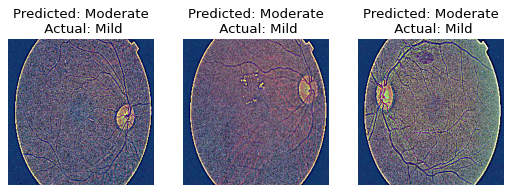

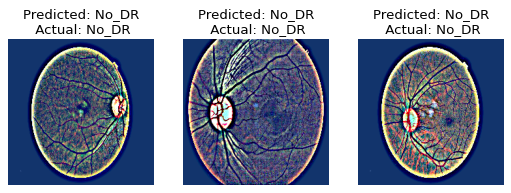

In [ ]:
load_weights()
display_examples(dataset, dataloader, net)